In [2]:
import warnings
warnings.filterwarnings('ignore')
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
sys.path.append('./../src/')
import dill
# dill.load_session(f'base.db')
# plt.rcParams["font.family"] = "sans-serif"
# plt.rcParams["font.sans-serif"] = "Helvetica"
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import utils
from utils import id_to_name, name_to_id
import pickle
import random
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(9)
np.random.seed(9)

date = "sep2024"
atleast = 2
with open(f"uberon_{date}_atleast{atleast}", "rb") as dill_file:
    subtree, subtree_meta, pos = dill.load(dill_file)
mlb=MultiLabelBinarizer().fit([[utils.id_to_name[node] for node in subtree.nodes]])

Mv, meta, _ = dill.load(open(f'./../data/GEO/preprocessed/450K_Mvalues_atleast{atleast}_samplewise', 'rb'))

meta_multi = utils.propagate_parent(subtree, meta, outdict=False)
meta_mlb = mlb.transform(meta_multi['tissue_name'].values)

In [4]:
Mv.shape
len(meta.tissue_name.unique())
len(subtree)

24

In [113]:
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

def combine_qualitative_cmaps(cmap1, cmap2):
    # Get the colors from both colormaps
    colors1 = cmap1.colors
    colors2 = cmap2.colors

    # Combine the colors
    combined_colors = colors1 + colors2

    # Create and return a new qualitative colormap
    return plt.cm.colors.ListedColormap(combined_colors)

def generate_colors(n):
    # cmap = plt.get_cmap('rainbow')
    # cmap = plt.get_cmap('gist_rainbow')
    # cmap = plt.get_cmap('gist_ncar')
    # cmap = plt.get_cmap('hsv')
    # cmap = plt.get_cmap('nipy_spectral')
    cmap1 = plt.get_cmap('Set1')
    cmap2 = plt.get_cmap('Set2')
    # combine them and build a new colormap
    cmap = combine_qualitative_cmaps(cmap1, cmap2)
    # rgba_colors = cmap(np.linspace(0, 1, n))
    rgba_colors = cmap.colors[:n]
    hex_colors = [mcolors.to_hex(color) for color in rgba_colors]
    
    # hex_colors = [
    #     '#e6194B', '#3cb44b', '#ffe119', '#4363d8', 
    #     '#f58231', '#911eb4', '#42d4f4', 
    #     '#f032e6', '#bfef45', '#fabed4', 
    #     '#469990', '#dcbeff', '#9A6324', 
    #     '#fffac8', '#800000', '#aaffc3', 
    #     '#808000', '#ffd8b1', '#000075', 
    #     '#a9a9a9', '#ffffff', '#000000'
    # ]
    
    hex_colors = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
    "#911eb4", "#46f0f0", "#bcf60c",  "#800000",
    "#008080",  "#e6beff", "#f032e6", "#fabebe", "#9a6324", "#fffac8",
    "#aaffc3", "#808000", "#ffd8b1", "#000075", "#808080"
    ]

    return hex_colors

def generate_gradient_colors(base_color, n):
    base_rgb = mcolors.hex2color(base_color)
    r, g, b = base_rgb

    gradients = []
    buffer = 4
    # n = n+buffer
    for i in range(n):
        factor = i / (n) if n > 1 else 0.0
        gradient_color = (r + (1 - r) * factor, g + (1 - g) * factor, b + (1 - b) * factor)
        # gradient_color = (r * factor, g * factor, b * factor)
        # if i>(buffer-1): gradients.append(gradient_color)
        gradients.append(gradient_color)

    return gradients

def show_color_dots(colors):
    num_colors = len(colors)

    # Create a scatter plot with colored dots
    fig, ax = plt.subplots(figsize=(8, 1))
    ax.scatter(range(num_colors), [1] * num_colors, color=colors, s=1000)

    # Hide axes and labels
    ax.axis('off')

    plt.show()

def get_family_colors(subtree, display=False):
    '''
    uses generate_colors(), generate_gradient_colors()
    '''
    families = [list(x) for x in nx.weakly_connected_components(subtree)]
    families.sort(key=len, reverse=True)
    colors = generate_colors(len(families))
    print(colors)
    ordered = list()
    member_color = dict()
    for i, family in enumerate(families):
        member_children = {utils.id_to_name[member]: [utils.id_to_name[x] for x in nx.ancestors(subtree, member)] for member in family}
        
        head = max(member_children, key=lambda k: len(member_children[k]))
        family_tree = subtree.subgraph(family)
        # nx.draw(family_tree, with_labels=True
        family_ordered = list(reversed(list(nx.topological_sort(family_tree))))
        gradient_colors = generate_gradient_colors(colors[i], len(family))
        # print(gradient_colors)
        
        if display:
            show_color_dots(gradient_colors)
                                                                                
        member_color.update({utils.id_to_name[member]:gradient_colors[j] for j, member in enumerate(family_ordered)})
        ordered.extend([utils.id_to_name[member] for member in family_ordered])
        
    return member_color, ordered

colors, ordered = get_family_colors(subtree, display=False)
ordered

['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#bcf60c', '#800000', '#008080', '#e6beff', '#f032e6', '#fabebe', '#9a6324', '#fffac8', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']


['blood',
 'leukocyte',
 'myeloid leukocyte',
 'peripheral blood mononuclear cell',
 'neutrophil',
 'monocyte',
 'lymphocyte',
 'umbilical cord blood',
 'simple columnar epithelium',
 'reproductive structure',
 'nasal cavity epithelium',
 'prostate epithelium',
 'placenta',
 'exocrine gland',
 'pancreas',
 'liver',
 'islet of Langerhans',
 'saliva',
 'myoblast',
 'sperm',
 'embryonic stem cell',
 'fibroblast',
 'breast',
 'visceral fat']

In [114]:
pancreas_index = ordered.index("pancreas")
islet_index = ordered.index("islet of Langerhans")

if abs(pancreas_index - islet_index) > 1:
    # Remove islet of Langerhans
    ordered.remove("islet of Langerhans")
    
    # Insert islet of Langerhans next to pancreas
    if pancreas_index < len(ordered) - 1:
        ordered.insert(pancreas_index + 1, "islet of Langerhans")
    else:
        ordered.insert(pancreas_index, "islet of Langerhans")
ordered

['blood',
 'leukocyte',
 'myeloid leukocyte',
 'peripheral blood mononuclear cell',
 'neutrophil',
 'monocyte',
 'lymphocyte',
 'umbilical cord blood',
 'simple columnar epithelium',
 'reproductive structure',
 'nasal cavity epithelium',
 'prostate epithelium',
 'placenta',
 'exocrine gland',
 'pancreas',
 'islet of Langerhans',
 'liver',
 'saliva',
 'myoblast',
 'sperm',
 'embryonic stem cell',
 'fibroblast',
 'breast',
 'visceral fat']

In [4]:
# with open("colors_ordered", "wb") as f:
#     dill.dump([colors, ordered], f, protocol=4)

# figure 1

## ontology

In [30]:
date = 'sep2024'
atleast = 2
import dill

with open(f"uberon_{date}_atleast{atleast}_rooted", "rb") as dill_file:
    rooted_tree, rooted_pos = dill.load(dill_file)

In [33]:
blue = '#00bfff'
orange = '#FFA500'
white = '#ffffff'
lightgrey = '#a9a9a9'
darkgrey = '#333333'

colors_id = {utils.name_to_id[tissue]:color for tissue,color in colors.items()}
colors_list = [colors_id[node] if node in colors_id.keys() else lightgrey for node in rooted_tree.nodes]

In [34]:
len(rooted_tree)

25

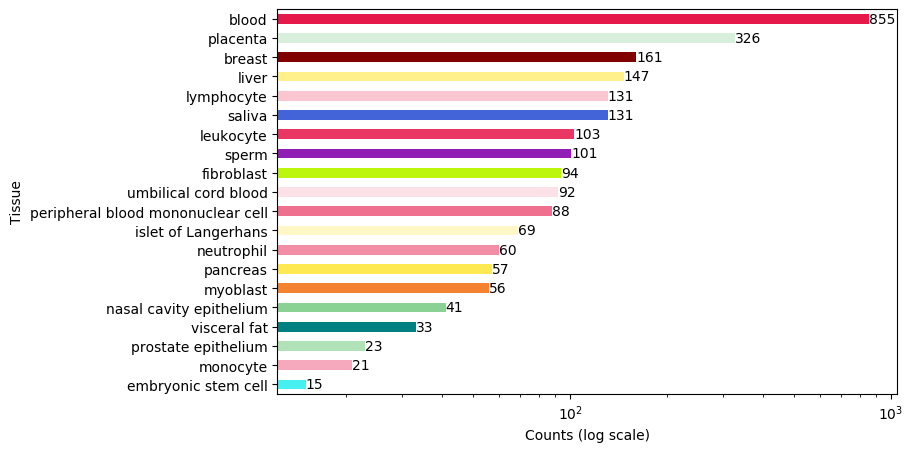

In [35]:
# Calculate value counts and sort them
value_counts = meta['tissue_name'].value_counts().sort_values(ascending=True)
ordered_counts = {k:value_counts[k] for k in ordered if k in value_counts.keys()}

plt.figure(figsize=(8, 5))
# value_counts.plot(kind='barh', color=[colors.get(x, 'gray') for x in value_counts.index])
# plt.xlabel('Counts')
# plt.ylabel('Tissue')
# plt.yticks(rotation=45)
# plt.show()

# Plot with horizontal bars and apply color
ax = value_counts.plot(kind='barh', color=[colors.get(x, 'gray') for x in value_counts.index])

# Set the x-axis to logarithmic scale
ax.set_xscale('log')

# Annotate each bar with its value
for i, (index, value) in enumerate(value_counts.items()):
    ax.text(value, i, str(value), ha='left', va='center', fontsize=10, color='black')

# Add labels and title
plt.xlabel('Counts (log scale)')
plt.ylabel('Tissue')
# plt.title('Tissue Counts with Logarithmic Scale and Annotations')

# Show plot
plt.show()


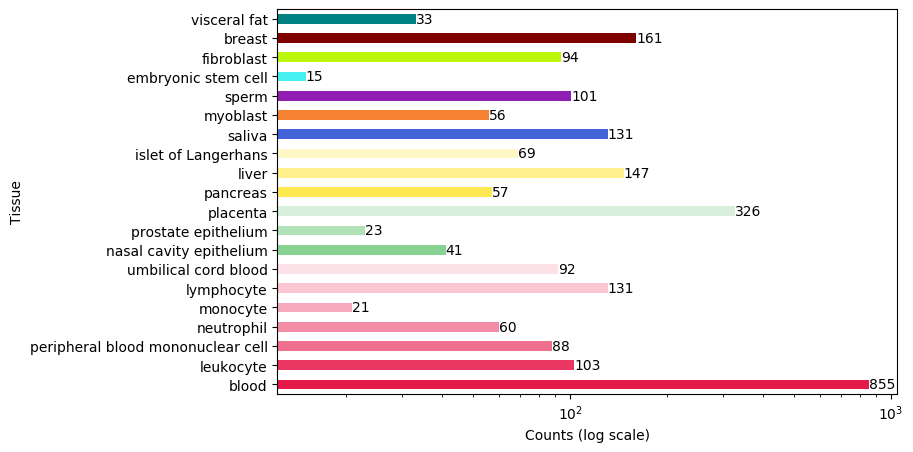

In [36]:
# Calculate value counts and sort them
value_counts = meta['tissue_name'].value_counts().sort_values(ascending=True)
ordered_counts = pd.Series({k:value_counts[k] for k in ordered if k in value_counts.keys()})

plt.figure(figsize=(8, 5))
# value_counts.plot(kind='barh', color=[colors.get(x, 'gray') for x in value_counts.index])
# plt.xlabel('Counts')
# plt.ylabel('Tissue')
# plt.yticks(rotation=45)
# plt.show()

# Plot with horizontal bars and apply color
ax = ordered_counts.plot(kind='barh', color=[colors.get(x, 'gray') for x in ordered_counts.index])

# Set the x-axis to logarithmic scale
ax.set_xscale('log')

# Annotate each bar with its value
for i, (index, value) in enumerate(ordered_counts.items()):
    ax.text(value, i, str(value), ha='left', va='center', fontsize=10, color='black')

# Add labels and title
plt.xlabel('Counts (log scale)')
plt.ylabel('Tissue')
# plt.title('Tissue Counts with Logarithmic Scale and Annotations')

# Show plot
plt.show()

In [37]:
print(ordered_counts.to_latex())

\begin{tabular}{lr}
\toprule
{} &    0 \\
\midrule
blood                             &  855 \\
leukocyte                         &  103 \\
peripheral blood mononuclear cell &   88 \\
neutrophil                        &   60 \\
monocyte                          &   21 \\
lymphocyte                        &  131 \\
umbilical cord blood              &   92 \\
nasal cavity epithelium           &   41 \\
prostate epithelium               &   23 \\
placenta                          &  326 \\
pancreas                          &   57 \\
liver                             &  147 \\
islet of Langerhans               &   69 \\
saliva                            &  131 \\
myoblast                          &   56 \\
sperm                             &  101 \\
embryonic stem cell               &   15 \\
fibroblast                        &   94 \\
breast                            &  161 \\
visceral fat                      &   33 \\
\bottomrule
\end{tabular}



In [38]:
import re

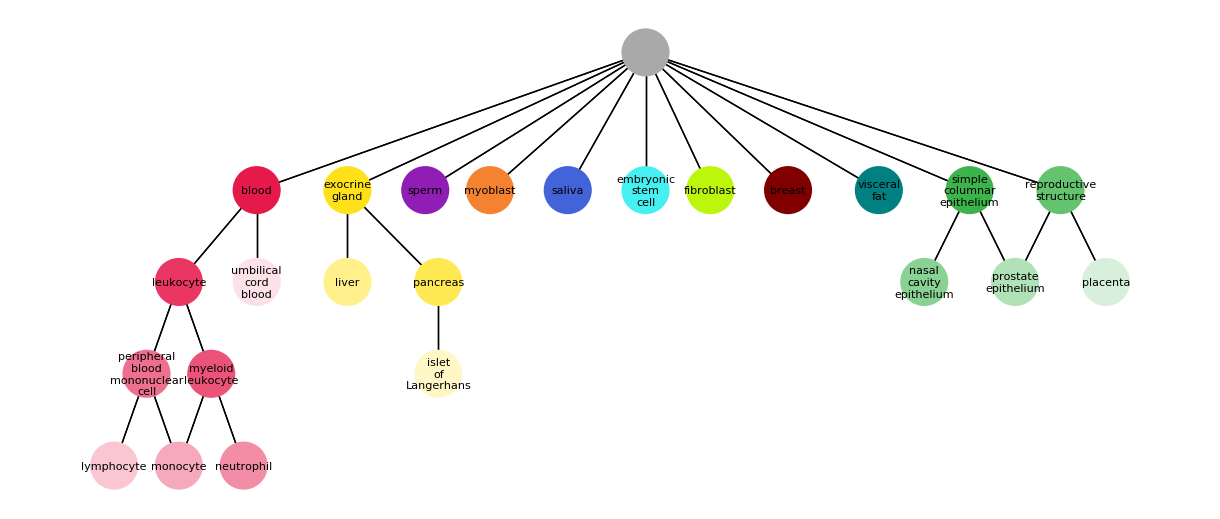

In [211]:
plt.figure(figsize=(12,5))
node_size=1000

font_size=8

label_dict={key:id_to_name[key] if key in id_to_name.keys() else '' for key in rooted_tree.nodes() }
for key in label_dict.keys():
    if key=='root': label_dict[key]=''
    if len(re.split(r' |-', label_dict[key]))>4:
        label_dict[key]=" ".join(re.split(r' |-', label_dict[key])[:3])+"\n..."
    label_dict[key]=label_dict[key].replace(" ", "\n")
    label_dict[key]=label_dict[key].replace("-", "-\n")

meta_node=[name_to_id[x] for x in meta['tissue_name'].unique() if name_to_id[x] in rooted_pos.keys()]
# single_node = [name_to_id[x] for x in single_meta['tissue_name'].unique() if name_to_id[x] in rooted_pos.keys()]
# collapsed_node = list(set(sample_tree.nodes))
# small_node = [x for x in set(subtree.nodes)-set(meta_node)-set(collapsed_node)]
# rest_node=[x for x in set(subtree_large.nodes)-set(meta_node)-set(small_node)-set(collapsed_node)]
rest_node=[x for x in set(rooted_tree.nodes)-set(meta_node)]

nx.draw(rooted_tree, rooted_pos, nodelist=meta_node, node_color=white, labels=label_dict, with_labels=False, arrows=False, 
            font_size=font_size, node_size=node_size, node_shape='o') # GREY
nx.draw(rooted_tree, rooted_pos, nodelist=rest_node, node_color=white, labels=label_dict, with_labels=False, arrows=False, 
            font_size=font_size, node_size=node_size, node_shape='o') # WHITE
nx.draw_networkx_labels(rooted_tree, rooted_pos, label_dict, font_color="black", font_size=font_size)

nx.draw_networkx_nodes(rooted_tree, rooted_pos, node_color=colors_list, node_size=node_size, edgecolors=colors_list, linewidths=3)

# rest_edges = set(subtree_large.edges()) - set(extra_edges.edges())
# nx.draw_networkx_edges(rest_edges, pos, edge_color='black', arrows=False)
# nx.draw_networkx_edges(extra_edges, pos, edge_color=grey, style='dashed')

# plt.savefig("./../figures/ontology_colored.png", bbox_inches='tight', dpi=300)
plt.savefig("./../figures/ontology_colored.pdf", bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

In [17]:
with open(f"uberon_{date}_atleast{atleast}_zero_rooted", "rb") as dill_file:
    zero_tree_rooted, zero_pos_rooted = dill.load(dill_file)

In [18]:
with open(f"single", "rb") as dill_file:
    single_Mv, single_meta = dill.load(dill_file)

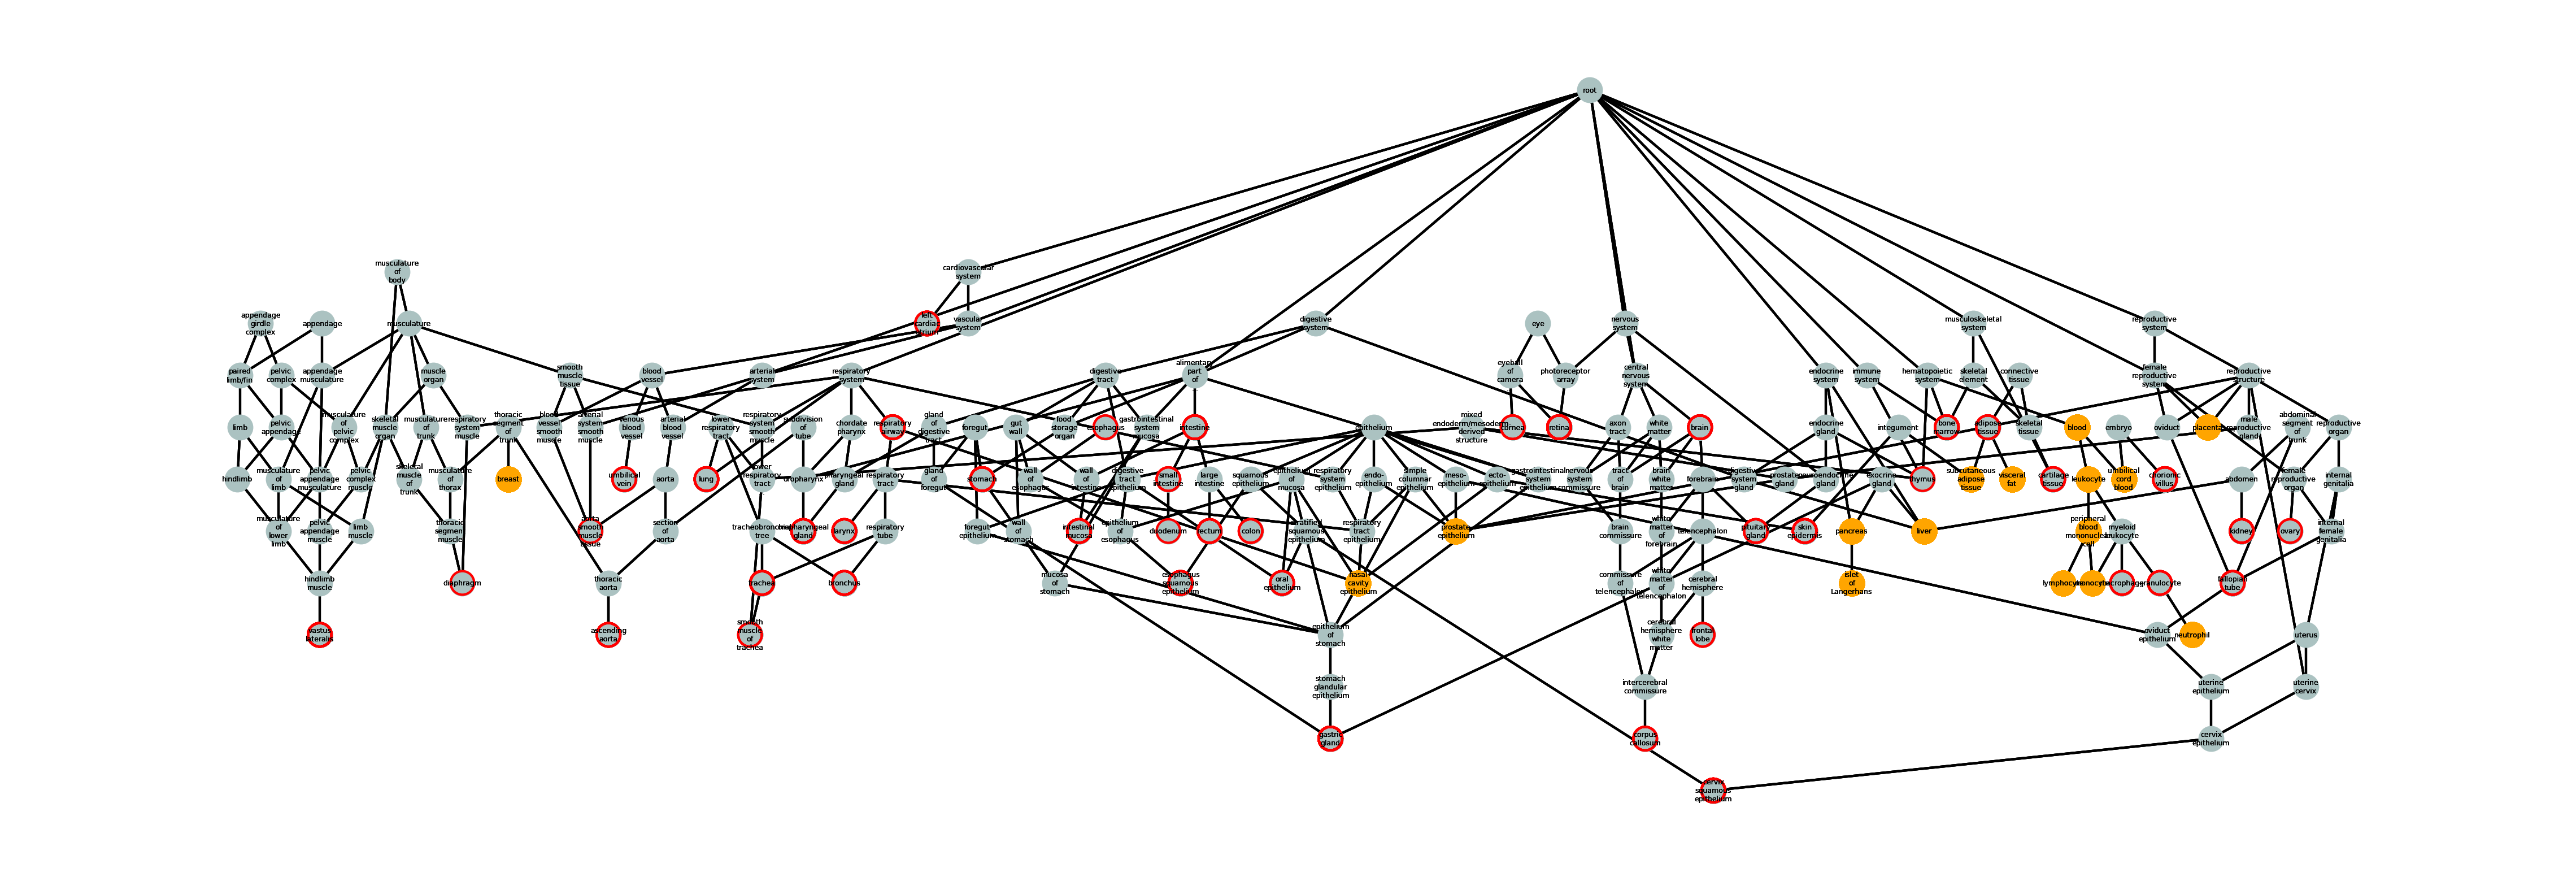

In [20]:
font_size = 3
node_size = 100

zero_pos_rooted = graphviz_layout(zero_tree_rooted, prog='dot', root='root')
for key in zero_pos_rooted.keys():
    if key=="root": 
        x,y=zero_pos_rooted[key]
        zero_pos_rooted[key]=(x, -y)
    else: continue
    
for key in zero_pos_rooted.keys():
    x,y=zero_pos_rooted[key]
    zero_pos_rooted[key]=(x,-y)
label_dict={key:id_to_name[key] if key in id_to_name.keys() else '' for key in zero_tree_rooted.nodes() }
for key in label_dict.keys():
    if len(re.split(r' |-', label_dict[key]))>4:
        label_dict[key]=" ".join(re.split(r' |-', label_dict[key])[:3])+"\n..."
    label_dict[key]=label_dict[key].replace(" ", "\n")
    label_dict[key]=label_dict[key].replace("-", "-\n")
zero_label=dict((k, label_dict[k]) for k in list(zero_tree_rooted.nodes()) if k in label_dict)

meta_node=[name_to_id[x] for x in meta['tissue_name'] if name_to_id[x] in zero_tree_rooted.nodes()]
single_node = [name_to_id[x] for x in list(single_meta['tissue_name'].values) if name_to_id[x] in zero_tree_rooted.nodes()]
rest_node=[x for x in set(zero_tree_rooted.nodes)-set(meta_node)-set(single_node)]

#display final structure
blue = '#00bfff'
orange = '#FFA500'
green = '#90EE90'
grey = '#abc2c1'

plt.figure(dpi=300, figsize=(15,5))
nx.draw(zero_tree_rooted, zero_pos_rooted, nodelist=meta_node, node_color=orange, labels=zero_label, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # meta = ORANGE
nx.draw(zero_tree_rooted, zero_pos_rooted, nodelist=rest_node, node_color=grey, labels=zero_label, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # rest = GREY
nx.draw(zero_tree_rooted, zero_pos_rooted, nodelist=single_node, node_color=grey, labels=zero_label, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # zeroshot = GREY
nx.draw_networkx_nodes(zero_tree_rooted, zero_pos_rooted, node_color='none', nodelist=single_node, node_size=node_size, edgecolors='red', linewidths=1)

text = nx.draw_networkx_labels(zero_tree_rooted, zero_pos_rooted, labels=zero_label,font_size=font_size)
for _, t in text.items():
    t.set_rotation('horizontal') 

# plt.savefig("./../figures/ontology_zero.pdf", bbox_inches='tight', dpi=300)
# plt.show()

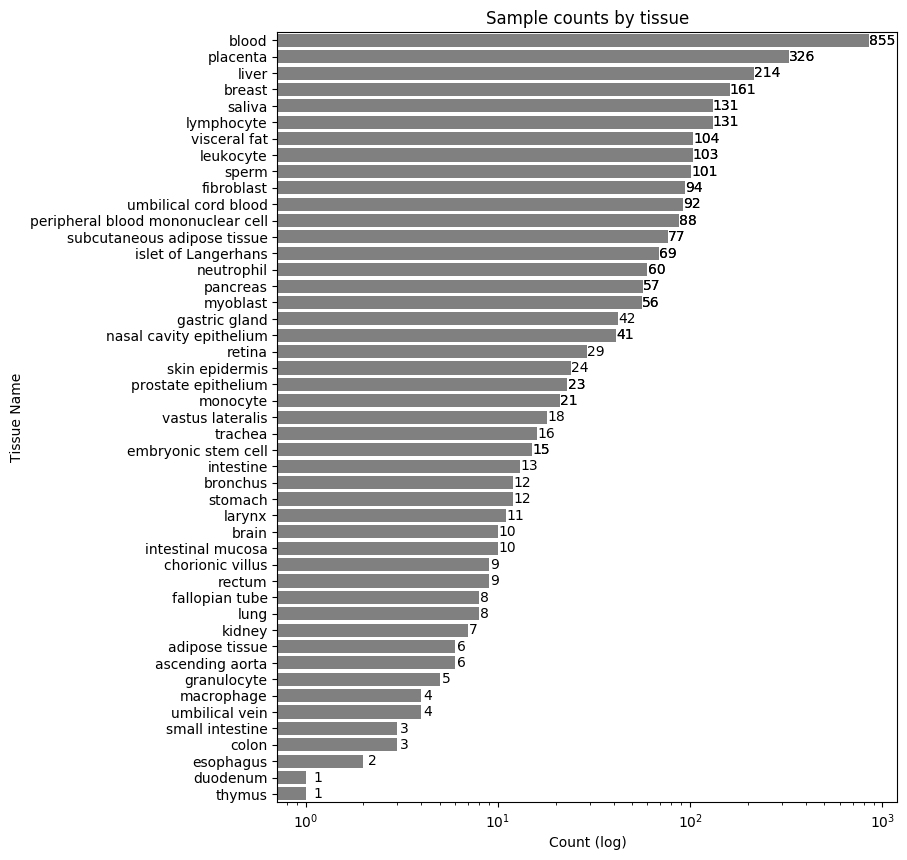

In [ ]:
plt.figure(figsize=(8,10))
# Plot the larger DataFrame first
sns.countplot(data=all_meta_without, y='tissue_name', order=all_meta_without['tissue_name'].value_counts().index, color='grey')
# Plot the smaller DataFrame overlaid on top
sns.countplot(data=mult_meta, y='tissue_name', order=all_meta_without['tissue_name'].value_counts().index, color='grey')

ax = plt.gca()
for p in ax.patches:
    if np.isnan(p.get_width()):
        continue
    ax.text(p.get_width() + 0.1, p.get_y() + p.get_height() / 2, '%d' % int(p.get_width()), 
            fontsize=10, ha='left', va='center', color='black')

plt.xscale('log')
plt.title('Sample counts by tissue')
plt.xlabel('Count (log)')
plt.ylabel('Tissue Name')
plt.show()

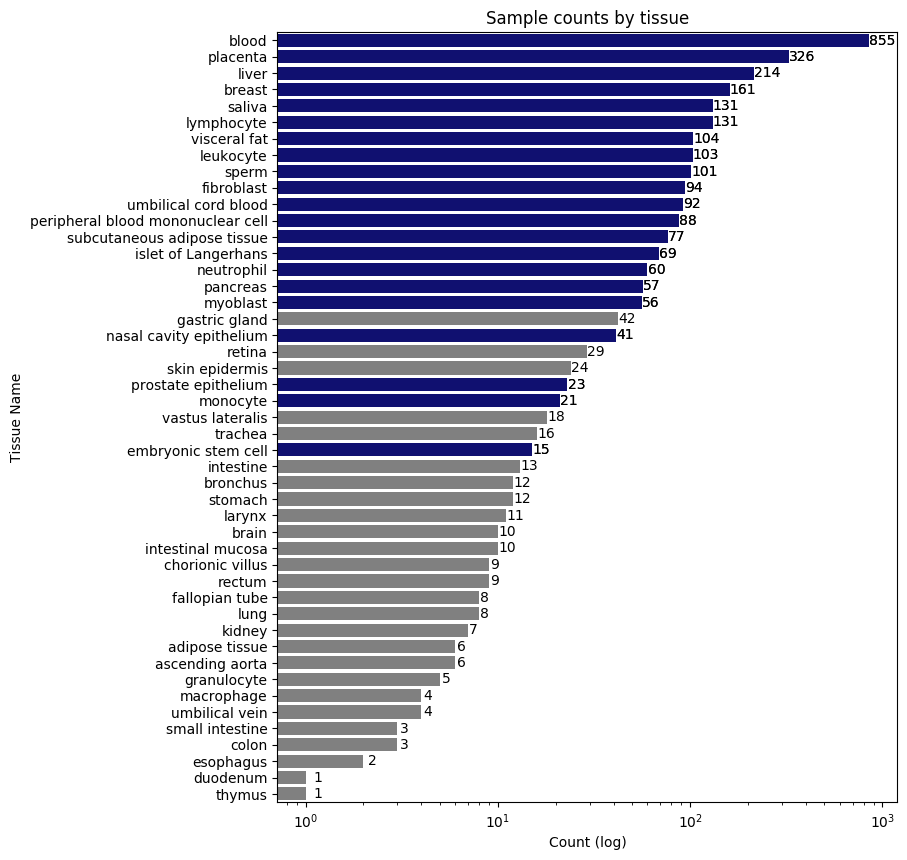

In [ ]:
plt.figure(figsize=(8,10))
# Plot the larger DataFrame first
sns.countplot(data=all_meta_without, y='tissue_name', order=all_meta_without['tissue_name'].value_counts().index, color='grey')
# Plot the smaller DataFrame overlaid on top
sns.countplot(data=mult_meta, y='tissue_name', order=all_meta_without['tissue_name'].value_counts().index, color='navy')

ax = plt.gca()
for p in ax.patches:
    if np.isnan(p.get_width()):
        continue
    ax.text(p.get_width() + 0.1, p.get_y() + p.get_height() / 2, '%d' % int(p.get_width()), 
            fontsize=10, ha='left', va='center', color='black')

plt.xscale('log')
plt.title('Sample counts by tissue')
plt.xlabel('Count (log)')
plt.ylabel('Tissue Name')
plt.show()

## diffmeth heatmap

In [11]:
# manifest = pd.read_csv("annotated_manifest.csv.gz", sep="\t", index_col="probe")
manifest = dill.load(open(f'annotated_manifest', 'rb'))
probe_to_gene = dill.load(open(f'probe_to_gene', 'rb'))

tissue_list = sorted(meta.tissue_name.unique())
tissue_by_diffmeth = pd.DataFrame(index=tissue_list)

diffmeth_res = dill.load(open(f'./../data/GEO/diffmeth/diffmeth_all', 'rb'))
tissue_to_probes = {tissue: list(res[res['PValue']<res['PValue_cutoff']].index) for tissue, res in diffmeth_res.items()}

tissue_by_diffmeth['Total'] = [len(tissue_to_probes[tissue])for tissue in tissue_list]

tissue_to_CGI = {tissue:Counter(manifest.loc[tissue_to_probes[tissue]]['Knowledgebase'].values.tolist()) for tissue in tissue_list}
tissue_to_CGI_df = pd.DataFrame.from_dict(tissue_to_CGI, orient='index')

tissue_by_diffmeth = pd.concat([tissue_by_diffmeth, tissue_to_CGI_df], axis=1)

In [12]:
from matplotlib.colors import LinearSegmentedColormap

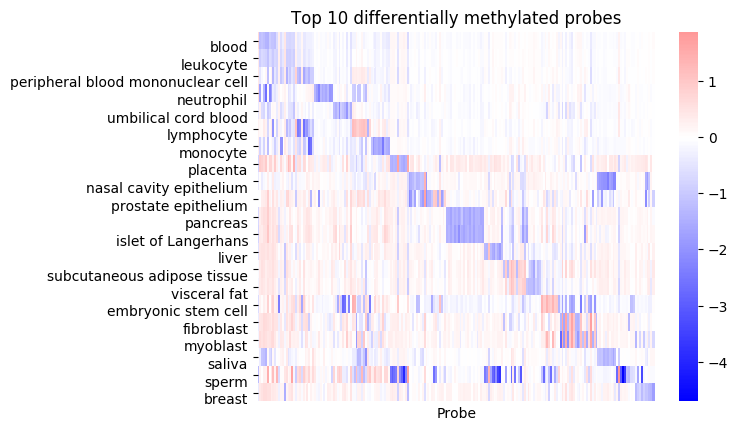

In [14]:
res_per_tissue_ordered = {k:diffmeth_res[k] for k in ordered if k in diffmeth_res.keys()}
    
all_top_res = pd.DataFrame()
for tissue in res_per_tissue_ordered.keys():
    all_top_res = pd.concat([all_top_res, res_per_tissue_ordered[tissue].sort_values(by="PValue")[:10]], axis=0)
all_top_res.index.rename("Probe", inplace=True)

foldchange = pd.DataFrame(index=all_top_res.index, 
                          # columns=res_per_tissue_ordered.keys()
                         )
for tissue in res_per_tissue_ordered.keys():
    tissue_fc = res_per_tissue_ordered[tissue]['fold_change']
    tissue_fc.rename(tissue, inplace=True)
    tissue_fc.index.rename("Probe", inplace=True)

    foldchange = foldchange.merge(tissue_fc, on="Probe", how='left')
    
# # Set the center of the colormap to align with 0
# center_val = 0
# vmax = max(np.abs(data.min()), np.abs(data.max()))

# # Create the cluster map
# sns.clustermap(data, cmap=cmap, center=center_val, vmax=vmax, vmin=-vmax)

cmap_colors = ['#0000FF', '#ffffff', '#FF0000']  # Blue, Gray, Red
cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)

# plt.figure(1, figsize=(5,5))
plt.figure(1)
s = sns.heatmap(foldchange.T,
                # cmap="coolwarm",
                cmap=cmap,
                vmin=foldchange.fillna(0).min().min(),
                vmax=foldchange.fillna(0).max().max(),
                yticklabels=True, 
                xticklabels=False,
                cbar=True,
                center=0)
s.set_yticklabels(s.get_yticklabels(), rotation=0, ha='right',  va='top')
# s.set_yticklabels(s.get_yticklabels(), rotation=45, ha='right')
plt.title(f"Top 10 differentially methylated probes")
# plt.savefig("./../figures/diffmeth_top10.pdf", bbox_inches='tight')
plt.show()

In [26]:
save_dill = False

if save_dill:
    with open('diffmeth_heatmap_foldchange', 'wb') as f:
        dill.dump(foldchange.T, f)

# figure 2

## performance by minipatch threshold

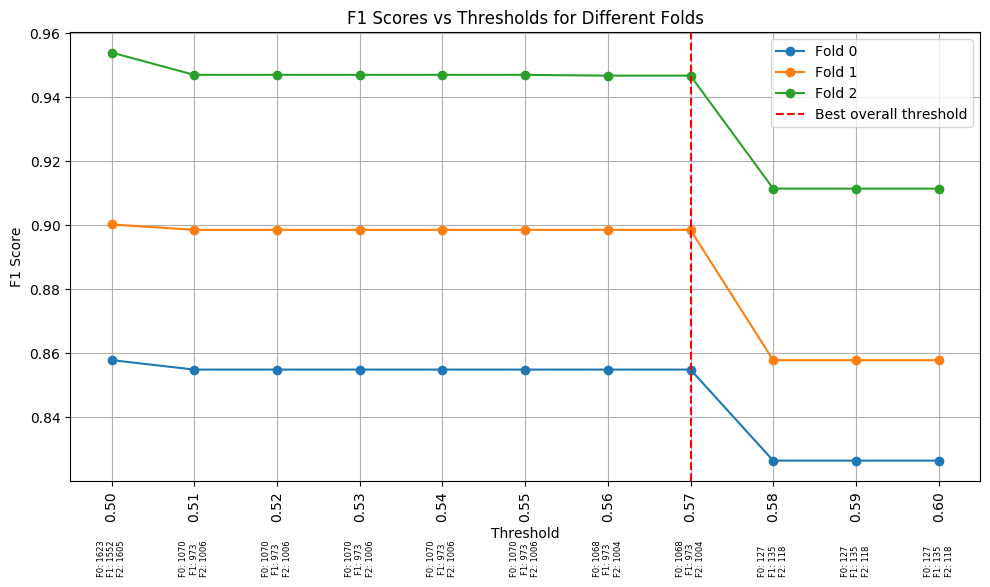

In [59]:
import matplotlib.pyplot as plt
import re

def read_data(filename):
    with open(filename, 'r') as file:
        content = file.read()

    folds = content.split('Fold')[1:]
    data = []

    for fold in folds:
        fold_data = []
        for line in fold.split('\n'):
            if 'Threshold:' in line:
                threshold = float(line.split(':')[1].strip())
            elif 'Number of probes:' in line:
                probe_count = int(line.split(':')[1].strip())
            elif 'F1 score:' in line:
                f1_score = float(line.split(':')[1].strip())
                fold_data.append((threshold, f1_score, probe_count))
        data.append(fold_data)

    return data


def plot_data(data):
    plt.figure(figsize=(10, 6), dpi=100)

    for i, fold_data in enumerate(data):
        thresholds, f1_scores, probe_counts = zip(*fold_data)
        plt.plot(thresholds, f1_scores, marker='o', label=f'Fold {i}')

    plt.axvline(x=0.57, color='r', linestyle='--', label='Best overall threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores vs Thresholds for Different Folds')
    plt.legend()
    plt.grid(True)

    ax = plt.gca()
    ax.set_xticks(thresholds)
    ax.set_xticklabels([f'{t:.2f}' for t in thresholds], rotation=90)

    for i, t in enumerate(thresholds):
        probe_text = '\n'.join([f'F{j}: {fold_data[i][2]}' for j, fold_data in enumerate(data)])
        plt.text(t, ax.get_ylim()[0]-0.03, probe_text, rotation=90, va='bottom', ha='center', fontsize=6)

    plt.tight_layout()
    # plt.savefig('output_plot.png', dpi=300, bbox_inches='tight')
    # plt.close()
    plt.show()

# Read the data
filename = './../data/GEO/minipatch/minipatch_crossvalidation_frequency_all.txt'
data = read_data(filename)

# Plot the data
plot_data(data)

In [61]:
filename = './../data/GEO/minipatch/frequency_results_[0.4,0.6].txt'
data = read_data(filename)
data

[[(0.4, 0.8573560094145779, 9566),
  (0.42, 0.8573560094145779, 9566),
  (0.44, 0.8577768718703697, 1636),
  (0.46, 0.8578673694563914, 1623),
  (0.48, 0.8578673694563914, 1623),
  (0.5, 0.8578673694563914, 1623),
  (0.52, 0.8549031114228317, 1070),
  (0.54, 0.8549031114228317, 1070),
  (0.56, 0.8549031114228317, 1068),
  (0.58, 0.8264406133216508, 127),
  (0.6, 0.8264406133216508, 127)],
 [(0.4, 0.9069692421360932, 9401),
  (0.42, 0.9069692421360932, 9401),
  (0.44, 0.89980393819369, 1564),
  (0.46, 0.9002710641185231, 1552),
  (0.48, 0.9002710641185231, 1552),
  (0.5, 0.9002710641185231, 1552),
  (0.52, 0.8985852551428444, 973),
  (0.54, 0.8985852551428444, 973),
  (0.56, 0.8985852551428444, 973),
  (0.58, 0.8578420040304506, 135),
  (0.6, 0.8578420040304506, 135)],
 [(0.4, 0.9525129831172344, 9506),
  (0.42, 0.9525129831172344, 9506),
  (0.44, 0.9543215416582975, 1618),
  (0.46, 0.9540220053745849, 1605),
  (0.48, 0.9540220053745849, 1605),
  (0.5, 0.9540220053745849, 1605),
  (0.52

In [62]:
save_dill = False

if save_dill:
    filename = './../data/GEO/minipatch/minipatch_crossvalidation_frequency_all.txt'
    data = read_data(filename)
    with open("./../figures/minipatch_crossvalidation_frequency_[0.5,0.6]", "wb") as f:
        dill.dump(data, f)
        
    filename = './../data/GEO/minipatch/frequency_results_[0.4,0.6].txt'
    data = read_data(filename)
    with open("./../figures/minipatch_crossvalidation_frequency_[0.4,0.6]", "wb") as f:
        dill.dump(data, f)

## old

In [93]:
from mplearn.feature_selection._adaptive_stable_minipatch_selection import AdaSTAMPS
from mplearn.feature_selection.base_selector import DecisionTreeSelector

Mv, meta, mapping = dill.load(open(f'./../data/GEO/preprocessed/450K_Mvalues_atleast2_samplewise', 'rb'))
le=LabelEncoder().fit(meta['tissue_name'].unique())
meta_le=le.transform(meta['tissue_name'].values)

In [94]:
filename = f"_default_{int(Mv.shape[1])}"
minipatch_location = f"./../data/GEO/minipatch/minipatch{filename}_all_selector"
print(f"loading minipatch selector from {minipatch_location}")
fitted_selector = dill.load(open(minipatch_location, 'rb'))

selection_frequency_threshold = 0.45
selection_freq = pd.DataFrame(fitted_selector.Pi_hat_last_k_, index=Mv.columns)

loading minipatch selector from ./../data/GEO/minipatch/minipatch_default_473821_all_selector


In [95]:
acc_list = list()
jacc_list = list()
precs_list = list()
prect_list = list()
numprobes_list = list()

filename = f"_default_473821"

minipatch_location = f"./../data/GEO/minipatch/minipatch{filename}_selectors_Mvs"
print(f"loading minipatch selectors and Mvs from {minipatch_location}")
fold_selectors, fold_Mvs = dill.load(open(minipatch_location, 'rb'))

selection_frequencies = [0.10, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, 0.85]

print(f"multiouput svm for each threshold...")
for selection_freq_threshold in selection_frequencies:
    
    print(f"selection_freq_threshold: {selection_freq_threshold}")
    for fold in range(3):
        print(f"fold: {fold}")
        
        fitted_selector = fold_selectors[fold]
        rest_Mv_all = fold_Mvs[fold][0]
        rest_meta = fold_Mvs[fold][1]
        holdout_Mv_all = fold_Mvs[fold][2]
        holdout_meta = fold_Mvs[fold][3]
        
        print(rest_Mv_all.shape, holdout_Mv_all.shape)

        rest_multi=utils.propagate_parent(subtree, rest_meta, outdict=False)
        rest_mlb=mlb.transform(rest_multi['tissue_name'].values)
        holdout_multi=utils.propagate_parent(subtree, holdout_meta, outdict=False)
        holdout_mlb=mlb.transform(holdout_multi['tissue_name'].values)
        
        rest_Mv_minipatch = fitted_selector.transform(rest_Mv_all.values, pi_thr=selection_freq_threshold)
        holdout_Mv_minipatch = fitted_selector.transform(holdout_Mv_all.values, pi_thr=selection_freq_threshold)
        
        print(rest_Mv_minipatch.shape, holdout_Mv_minipatch.shape)

        clf = MultiOutputClassifier(SVC(class_weight='balanced', kernel='linear', random_state=9))
        clf.fit(rest_Mv_minipatch, rest_mlb)

        true=holdout_mlb
        pred=clf.predict(holdout_Mv_minipatch)
        
        if fold==2:
            skip_idx = [list(mlb.classes_).index(x) for x in ['nasal cavity epithelium', 'neutrophil','islet of Langerhans','subcutaneous adipose tissue','embryonic stem cell','prostate epithelium','myoblast']]
            precision_subset = [value for index, value in enumerate(precision_score(true,pred, average=None)) if index not in skip_idx]
            prect = round(np.mean(precision_subset), 4)
        else:
            prect = round(precision_score(np.array(true).transpose(), np.array(pred).transpose(), average="samples"),4)

        # print(f'acc-samp: {round(accuracy_score(true, pred),4)}')
        # print(f'jacc-samp: {round(jaccard_score(true, pred, average="samples"),4)}')
        # print(f'prec-samp: {round(precision_score(true, pred, average="samples"),4)}')
        # print(f'prec-tiss: {prect}')
        # print()

        acc_list += [round(accuracy_score(true, pred),4)]
        jacc_list += [round(jaccard_score(true, pred, average="samples"),4)]
        precs_list += [round(precision_score(true, pred, average="samples"),4)]
        prect_list += [prect]
        numprobes_list += [rest_Mv_minipatch.shape[1]]

loading minipatch selectors and Mvs from ./../data/GEO/minipatch/minipatch_default_473821_selectors_Mvs
multiouput svm for each threshold...
selection_freq_threshold: 0.1
fold: 0
(1929, 473821) (890, 473821)
(1929, 260791) (890, 260791)
fold: 1
(1855, 473821) (964, 473821)
(1855, 260791) (964, 260791)
fold: 2
(1854, 473821) (965, 473821)
(1854, 260791) (965, 260791)
selection_freq_threshold: 0.35
fold: 0
(1929, 473821) (890, 473821)
(1929, 6416) (890, 6416)
fold: 1
(1855, 473821) (964, 473821)
(1855, 6416) (964, 6416)
fold: 2
(1854, 473821) (965, 473821)
(1854, 6416) (965, 6416)
selection_freq_threshold: 0.4
fold: 0
(1929, 473821) (890, 473821)
(1929, 4662) (890, 4662)
fold: 1
(1855, 473821) (964, 473821)
(1855, 4662) (964, 4662)
fold: 2
(1854, 473821) (965, 473821)
(1854, 4662) (965, 4662)
selection_freq_threshold: 0.45
fold: 0
(1929, 473821) (890, 473821)
(1929, 719) (890, 719)
fold: 1
(1855, 473821) (964, 473821)
(1855, 719) (964, 719)
fold: 2
(1854, 473821) (965, 473821)
(1854, 719

In [96]:
def average_of_three(input_list):
    return [round(sum(input_list[i:i+3]) / 3, 2) for i in range(0, len(input_list), 3) if i + 2 < len(input_list)]

# def se_of_three(

In [97]:
thresholds = list()
[thresholds.extend([x,x,x]) for x in selection_frequencies]
None

In [98]:
df = pd.DataFrame(index=thresholds)
df.index.name = "threshold"
df['prec-samp'] = precs_list
df['prec-tiss'] = prect_list
df['numProbes'] = numprobes_list

df.reset_index(inplace=True)
df['Group'] = df.index // 3
df_melted = pd.melt(df[["prec-samp", "prec-tiss", "Group", "threshold"]], id_vars=['threshold', 'Group'], var_name='Metric', value_name='Value')

In [99]:
second_axis = list()
for selection_frequency in selection_frequencies:
    minipatch_probes = list(selection_freq[selection_freq[0]>=selection_frequency].index)
    second_axis.append("("+str(len(minipatch_probes))+")")
second_axis

['(231460)',
 '(6576)',
 '(3995)',
 '(741)',
 '(47)',
 '(43)',
 '(39)',
 '(32)',
 '(13)']

ValueError: Could not interpret value `prec-tiss` for parameter `y`

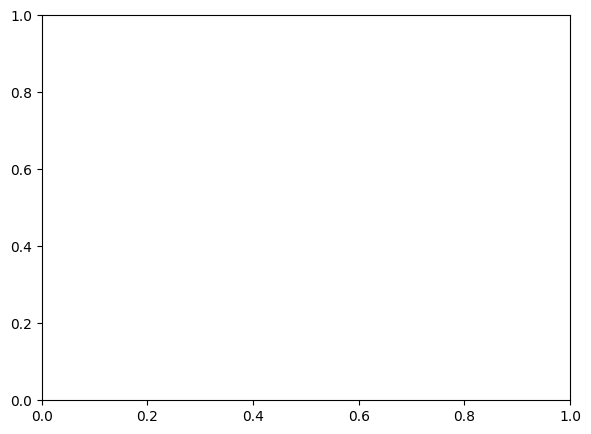

In [100]:
plt.figure(figsize=(15,5))

ax = plt.subplot(121)

col = ['prec-samp', 'threshold']
every_third_row_0 = df[col].iloc[0::3]
every_third_row_1 = df[col].iloc[1::3]
every_third_row_2 = df[col].iloc[2::3]

sns.lineplot(x='threshold', y='prec-tiss', data=every_third_row_0)
sns.lineplot(x='threshold', y='prec-tiss', data=every_third_row_1)
sns.lineplot(x='threshold', y='prec-tiss', data=every_third_row_2)

ax.legend(["fold: 0", "fold: 1", "fold: 2"])
ax.set_ylabel("Performance")
ax.set_xlabel("Selection frequency threshold", labelpad=15)
ax.set_title("Tissue-wise precision")

x_position = 0.45
y_max = 1
plt.axvline(x=x_position, color='r', linestyle='--')

ax2 = ax.twiny()
# Set the tick locations for the secondary x-axis same as primary x-axis
ax2.set_xticks(ax.get_xticks())
# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels([''] + second_axis)
ax2.xaxis.set_ticks_position('bottom')
ax2.tick_params(axis='x', pad=15)
# Set the label for the secondary x-axis at the bottom
ax2.xaxis.set_label_position('bottom')
ax2.set_xlabel('(Number of CpG)', labelpad=15)

ax = plt.subplot(122)

col = ['prec-samp', 'threshold']
every_third_row_0 = df[col].iloc[0::3]
every_third_row_1 = df[col].iloc[1::3]
every_third_row_2 = df[col].iloc[2::3]

sns.lineplot(x='threshold', y='prec-samp', data=every_third_row_0)
sns.lineplot(x='threshold', y='prec-samp', data=every_third_row_1)
sns.lineplot(x='threshold', y='prec-samp', data=every_third_row_2)

ax.legend(["fold: 0", "fold: 1", "fold: 2"])
ax.set_ylabel("Performance")
ax.set_xlabel("Selection frequency threshold", labelpad=15)
ax.set_title("Sample-wise precision")

x_position = 0.45
y_max = 1
plt.axvline(x=x_position, color='r', linestyle='--')

ax2 = ax.twiny()
# Set the tick locations for the secondary x-axis same as primary x-axis
ax2.set_xticks(ax.get_xticks())
# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels([''] + second_axis)
ax2.xaxis.set_ticks_position('bottom')
ax2.tick_params(axis='x', pad=15)
# Set the label for the secondary x-axis at the bottom
ax2.xaxis.set_label_position('bottom')
ax2.set_xlabel('(Number of CpG)', labelpad=15)

# plt.savefig("./../figures/perfbyprobe.pdf", bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))

ax = plt.subplot(211)

col = ['prec-tiss', 'threshold']
every_third_row_0 = df[col].iloc[0::3]
every_third_row_1 = df[col].iloc[1::3]
every_third_row_2 = df[col].iloc[2::3]

sns.lineplot(x='threshold', y='prec-tiss', data=every_third_row_0)
sns.lineplot(x='threshold', y='prec-tiss', data=every_third_row_1)
sns.lineplot(x='threshold', y='prec-tiss', data=every_third_row_2)

ax.set_xticks(thresholds)
ax.legend(["fold: 0", "fold: 1", "fold: 2"])
ax.set_ylabel("Performance")
ax.set_xlabel("Selection frequency threshold", labelpad=15)
ax.set_title("Tissue-wise precision")

x_position = 0.45
y_max = 1
plt.axvline(x=x_position, color='r', linestyle='--')

ax2 = ax.twiny()
# Set the tick locations for the secondary x-axis same as primary x-axis
ax2.set_xticks(ax.get_xticks())
# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(second_axis)
ax2.xaxis.set_ticks_position('bottom')
ax2.tick_params(axis='x', pad=15)
# Set the label for the secondary x-axis at the bottom
ax2.xaxis.set_label_position('bottom')
ax2.set_xlabel('(Number of CpG)', labelpad=15)

ax = plt.subplot(212)

col = ['prec-samp', 'threshold']
every_third_row_0 = df[col].iloc[0::3]
every_third_row_1 = df[col].iloc[1::3]
every_third_row_2 = df[col].iloc[2::3]

sns.lineplot(x='threshold', y='prec-samp', data=every_third_row_0)
sns.lineplot(x='threshold', y='prec-samp', data=every_third_row_1)
sns.lineplot(x='threshold', y='prec-samp', data=every_third_row_2)

ax.set_xticks(thresholds)
ax.legend(["fold: 0", "fold: 1", "fold: 2"])
ax.set_ylabel("Performance")
ax.set_xlabel("Selection frequency threshold", labelpad=15)
ax.set_title("Sample-wise precision")

x_position = 0.45
y_max = 1
plt.axvline(x=x_position, color='r', linestyle='--')

ax2 = ax.twiny()
# Set the tick locations for the secondary x-axis same as primary x-axis
ax2.set_xticks(ax.get_xticks())
# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(second_axis)
ax2.xaxis.set_ticks_position('bottom')
ax2.tick_params(axis='x', pad=15)
# Set the label for the secondary x-axis at the bottom
ax2.xaxis.set_label_position('bottom')
ax2.set_xlabel('(Number of CpG)', labelpad=15)

plt.tight_layout()

# plt.savefig("./../figures/perfbyprobe.pdf", bbox_inches='tight')
plt.show()

In [51]:
save_dill = False

if save_dill:
    with open('performance_per_threshold', 'wb') as f:
        dill.dump(df, f)

## pca

In [63]:
filename = f"_whole"
minipatch_location = f"./../data/GEO/minipatch/minipatch{filename}_selector"
print(f"loading minipatch selector from {minipatch_location}")
fitted_selector = dill.load(open(minipatch_location, 'rb'))

selection_frequency_threshold = 0.57
selection_freq = pd.DataFrame(fitted_selector.Pi_hat_last_k_, index=Mv.columns)
minipatch_probes = list(selection_freq[selection_freq[0]>=selection_frequency_threshold].index)
Mv45 = Mv[minipatch_probes]

loading minipatch selector from ./../data/GEO/minipatch/minipatch_whole_selector


In [64]:
def plot_pca_with_exclude(subtree, Mv_data, meta_data, exclude):

    pca = PCA(n_components=2)
    without_meta = meta_data[~meta_data['tissue_name'].isin(exclude)]
    without_Mv = Mv_data.loc[without_meta.index]
    without_pca = pca.fit_transform(without_Mv)
    explained_variance = pca.explained_variance_ratio_

    cmap = plt.get_cmap('rainbow')
    n = len(without_meta['tissue_name'].unique())
    values = np.linspace(0, 1, n)
    
    colors, ordered = get_family_colors(subtree)
    ordered = [item for item in ordered if item not in exclude]

    plt.figure()
    lw = 2

    for target_name in ordered:
        color = colors[target_name]
        plt.scatter(
            without_pca[without_meta['tissue_name'] == target_name, 0], 
            without_pca[without_meta['tissue_name'] == target_name, 1], 
            color=color, 
            alpha=0.8, 
            lw=lw, 
            label=target_name
        )
        
    plt.legend(loc="center left", shadow=False, scatterpoints=1, bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.xlabel(f"PC1 ({explained_variance[0]})", fontsize=12)
    plt.ylabel(f"PC2 ({explained_variance[1]})", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if len(exclude)>0: plt.title(f"PCA without {exclude}", fontsize=12)
    else: plt.title(f"PCA", fontsize=12)
    None

In [65]:
# with open("colors", "wb") as f: 
#     dill.dump(colors, f)

In [66]:
def export_legend(legend, filename="./../figures/pca_legend.pdf", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

In [67]:
from sklearn.decomposition import PCA

Text(0.5, 1, 'PCA with minipatch (1050 CpGs)')

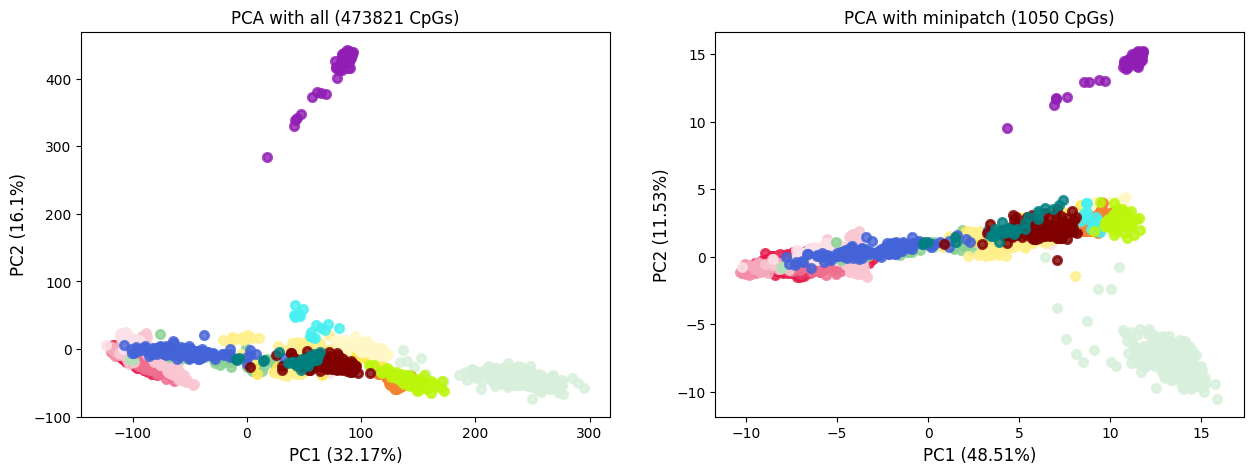

In [68]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
pca = PCA(n_components=2)
without_meta = meta
without_Mv = Mv.loc[without_meta.index]
without_pca_all = pca.fit_transform(without_Mv)
explained_variance = pca.explained_variance_ratio_
lw = 2
for target_name in ordered:
    color = colors[target_name]
    ax1.scatter(
        without_pca_all[without_meta['tissue_name'] == target_name, 0], 
        without_pca_all[without_meta['tissue_name'] == target_name, 1], 
        color=color, 
        alpha=0.8, 
        lw=lw, 
        label=target_name,
    )

# plt.legend(loc="center left", shadow=False, scatterpoints=1, bbox_to_anchor=(1, 0.5), fontsize=12)
ax1.set_xlabel(f"PC1 ({round(explained_variance[0], 4)*100}%)", fontsize=12)
ax1.set_ylabel(f"PC2 ({round(explained_variance[1], 4)*100}%)", fontsize=12)
# ax1.set_xticks(fontsize=12)
# ax1.set_yticks(fontsize=12)
ax1.set_title(f"PCA with all ({Mv.shape[1]} CpGs)")

ax2 = plt.subplot(122)
pca = PCA(n_components=2)
without_meta = meta
without_Mv = Mv45.loc[without_meta.index]
without_pca = pca.fit_transform(without_Mv)
explained_variance = pca.explained_variance_ratio_
lw = 2
for target_name in ordered:
    color = colors[target_name]
    ax2.scatter(
        without_pca[without_meta['tissue_name'] == target_name, 0], 
        without_pca[without_meta['tissue_name'] == target_name, 1], 
        color=color, 
        alpha=0.8, 
        lw=lw, 
        label=target_name,
    )
# Get the handles and labels of the current plot
handles, labels = ax2.get_legend_handles_labels()

# Create the legend with two columns using plt.legend
# plt.legend(handles, labels, loc="center left", shadow=False, scatterpoints=1, bbox_to_anchor=(1, 0.5), fontsize=12, ncol=2)
legend = plt.legend(handles, labels, loc="center left", shadow=False, scatterpoints=1, bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)
export_legend(legend)
legend.remove()
ax2.set_xlabel(f"PC1 ({round(explained_variance[0], 4)*100}%)", fontsize=12)
ax2.set_ylabel(f"PC2 ({round(explained_variance[1], 4)*100}%)", fontsize=12)
# ax2.set_xticks(fontsize=12)
# ax2.set_yticks(fontsize=12)
ax2.set_title(f"PCA with minipatch ({Mv45.shape[1]} CpGs)")

# plt.savefig("./../figures/pca_both.pdf", bbox_inches='tight')

In [69]:
pca_all = pd.DataFrame(without_pca_all, index=without_meta['tissue_name'])
pca_all

,0,1
tissue_name,,
placenta,237.198940,-43.556696
placenta,228.422063,-40.100779
placenta,239.099329,-29.912254
placenta,244.360138,-32.555254
placenta,235.186139,-46.777021
...,...,...
embryonic stem cell,64.585246,31.217787
embryonic stem cell,56.361647,25.672413
embryonic stem cell,80.782052,31.520705


In [70]:
pca_minipatch = pd.DataFrame(without_pca, index=without_meta['tissue_name'])
pca_minipatch

,0,1
tissue_name,,
placenta,14.001189,-7.324849
placenta,13.504867,-6.699714
placenta,14.727878,-7.267285
placenta,13.941906,-7.344060
placenta,12.980521,-7.502685
...,...,...
embryonic stem cell,9.231359,2.938849
embryonic stem cell,8.408333,2.665557
embryonic stem cell,9.413969,1.850945


In [71]:
save_dill = False

if save_dill:
    with open('./../figures/pca_all_minipatch', 'wb') as f:
        dill.dump([pca_all, pca_minipatch], f)

# figure 3

## AUC

In [ ]:
# pred_res = pd.DataFrame(columns = ['predict_proba', 'pred', 'true'])
# for fold in range(3):
#     print(f"fold: {fold}")
    
#     rest_Mv_all = fold_Mvs[fold][0]
#     rest_meta = fold_Mvs[fold][1]
#     holdout_Mv_all = fold_Mvs[fold][2]
#     holdout_meta = fold_Mvs[fold][3]
    
#     with open(f"./../data/GEO/minipatch/clf_default_{Mv.shape[1]}_fold{fold}", 'rb') as f:
#         fold_clf = dill.load(f)
        
#     fitted_selector = fold_selectors[fold]
#     selection_freq = pd.DataFrame(fitted_selector.Pi_hat_last_k_, index=rest_Mv_all.columns)
#     minipatch_probes = list(selection_freq[selection_freq[0]>=selection_frequency_threshold].index)
#     rest_Mv = rest_Mv_all[minipatch_probes]
#     holdout_Mv = holdout_Mv_all[rest_Mv.columns]
    
#     print(rest_Mv.shape, holdout_Mv.shape)
    
#     rest_meta = meta.loc[rest_Mv.index]
#     holdout_meta = meta.loc[holdout_Mv.index]
    
#     rest_multi=utils.propagate_parent(subtree, rest_meta, outdict=False)
#     rest_mlb=mlb.transform(rest_multi['tissue_name'].values)
#     holdout_multi=utils.propagate_parent(subtree, holdout_meta, outdict=False)
#     holdout_mlb=mlb.transform(holdout_multi['tissue_name'].values)

#     true=holdout_mlb
#     pred=fold_clf.predict(holdout_Mv.values)
#     # pred_prob = fold_clf.predict_proba(holdout_Mv.values)
#     pred_prob = np.transpose([y_pred[:, 1] for y_pred in fold_clf.predict_proba(holdout_Mv.values)])
#     pred_set = mlb.inverse_transform(pred)
#     true_set = mlb.inverse_transform(true)
#     for i, gse in enumerate(holdout_meta.index):
#         # pred_prob_gse = np.array([prob[i] for prob in pred_prob])
#         # pred_res.loc[f'f{fold}.{gse}'] = [pred_prob_gse, pred_set[i], true_set[i]]
#         pred_res.loc[f'f{fold}.{gse}'] = [pred_prob[i], pred_set[i], true_set[i]]

#     accs = round(accuracy_score(true, pred),4)
#     jaccs = round(jaccard_score(true, pred, average="samples"),4)    
#     precs = round(precision_score(true, pred, average="samples"),4)
#     prect = round(precision_score(true, pred, average="macro"), 4)
    
#     print(f'acc-samp: {accs}')
#     print(f'jacc-samp: {jaccs}')
#     print(f'prec-samp: {precs}')
#     print(f'prec-tiss: {prect}')
#     print()

In [52]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

In [73]:
filename = "_crossvalidation"
minipatch_location = f"./../data/GEO/minipatch/minipatch{filename}_selectors"
print(f"loading minipatch selectors from {minipatch_location}")
fold_selectors = dill.load(open(minipatch_location, 'rb'))

loading minipatch selectors from ./../data/GEO/minipatch/minipatch_crossvalidation_selectors


In [82]:
filename = "_crossvalidation"
pred_location = f"./../data/GEO/minipatch/multilabel{filename}_pred"
print(f"loading pred from {pred_location}")
pred_res = pickle.load(open(pred_location, 'rb'))

loading pred from ./../data/GEO/minipatch/multilabel_crossvalidation_pred


In [85]:
from sklearn.metrics import accuracy_score, jaccard_score, precision_score

In [86]:
y_true_bin = mlb.transform(pred_res['true'])
y_pred_bin = mlb.transform(pred_res['pred'])

acc_all = round(accuracy_score(y_true_bin, y_pred_bin),4)
jacc_all = round(jaccard_score(y_true_bin, y_pred_bin, average="samples"),4)    
precs_all = round(precision_score(y_true_bin, y_pred_bin, average="samples"),4)
prect_all = round(precision_score(y_true_bin, y_pred_bin, average="macro"),4)

print(acc_all, jacc_all, precs_all, prect_all)

0.7969 0.8931 0.9357 0.9432


In [87]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score

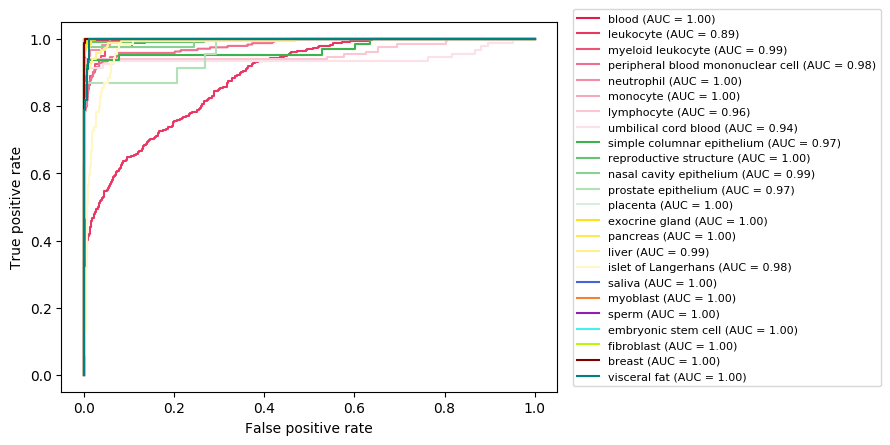

In [88]:
y_true_bin = mlb.transform(pred_res['true'])
tissue_roc = dict()
for i, tissue in enumerate(ordered):
    tissue_roc[tissue] = dict()
    mlb_idx = list(mlb.classes_).index(tissue)
    y_true_tissue = y_true_bin[:, mlb_idx]
    y_score_tissue = np.vstack(pred_res['predict_proba'])[:,mlb_idx]  # Assuming 'predict_proba' is a column containing probabilities

    fpr, tpr, _ = roc_curve(y_true_tissue, y_score_tissue)
    tissue_roc[tissue]['tpr'] = tpr
    tissue_roc[tissue]['fpr'] = fpr
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{tissue} (AUC = {roc_auc:.2f})', color=colors[tissue])
    plt.xlabel("False positive rate", fontsize=10)
    plt.ylabel("True positive rate", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # plt.scatter([], [], label=f'{tissue} (AUC = {roc_auc:.2f})', color=colors[tissue])
    plt.legend(bbox_to_anchor=(1.02, 1.05), fontsize=8)
# plt.savefig("./../figures/roc_all.pdf", bbox_inches='tight')

In [89]:
save_dill = True

if save_dill:
    with open('./../figures/roc', 'wb') as f:
        dill.dump(tissue_roc, f)

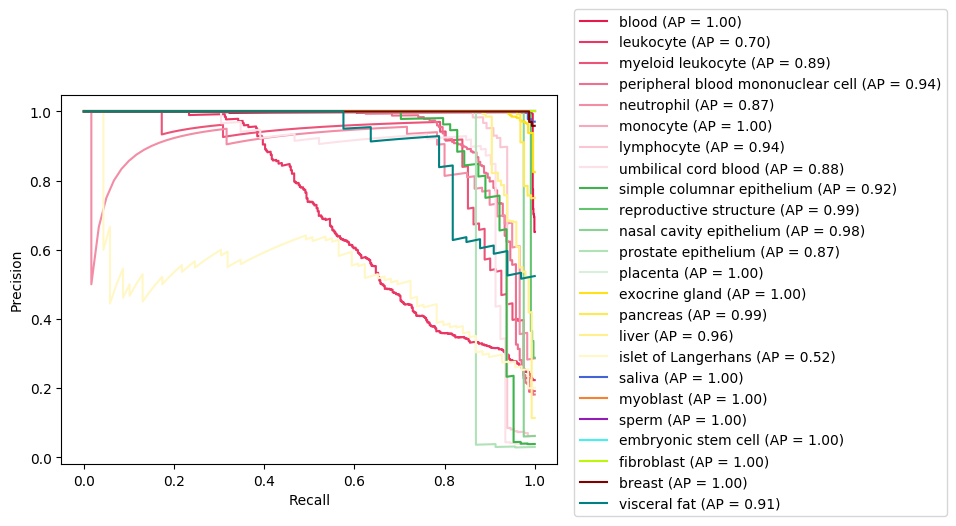

In [90]:
for i, tissue in enumerate(ordered):
    mlb_idx = list(mlb.classes_).index(tissue)
    y_true_tissue = y_true_bin[:, mlb_idx]
    y_score_tissue = np.vstack(pred_res['predict_proba'])[:,mlb_idx]  # Assuming 'predict_proba' is a column containing probabilities

    pr, rc, _ = precision_recall_curve(y_true_tissue, y_score_tissue)
    ave_pr = average_precision_score(y_true_tissue, y_score_tissue)

    plt.plot(rc, pr, label=f'{tissue} (AP = {ave_pr:.2f})', color=colors[tissue])
    plt.xlabel("Recall", fontsize=10)
    plt.ylabel("Precision", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # plt.scatter([], [], label=f'{tissue} (AUC = {roc_auc:.2f})', color=colors[tissue])
    plt.legend(bbox_to_anchor=(1.02, 1.25), fontsize=10)
# plt.savefig("./../figures/prc_all.pdf", bbox_inches='tight')

y_true_bin = mlb.transform(pred_res['true'])
# colors, ordered = get_family_colors(subtree)

In [29]:
# # Create a list of tissue names
# # tissue_names = list(meta_all['tissue_name'].unique())

# # Calculate the number of subplots needed
# num_subplots = len(mlb.classes_)
# num_rows = 6
# num_cols = 5

# # Create a figure with a 5 by 5 subplot grid
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# std = 2

# # Plot each tissue in a subplot
# for i, tissue in enumerate(ordered):
#     mlb_idx = list(mlb.classes_).index(tissue)
#     y_true_tissue = y_true_bin[:, mlb_idx]
#     y_score_tissue = np.vstack(pred_res['predict_proba'])[:,mlb_idx]
    
#     pr, rc, _ = precision_recall_curve(y_true_tissue, y_score_tissue)
    
#     #sort by pr
#     # paired_lists = list(zip(rc, pr))
#     # # Sort the paired lists based on the second list
#     # sorted_pairs = sorted(paired_lists, key=lambda x: x[1])
#     # rc, pr = zip(*sorted_pairs)
    
#     ave_pr = average_precision_score(y_true_tissue, y_score_tissue)

#     ax = axes[i]
    
#     # Plot histogram
#     ax.plot(rc, pr, label=f'{tissue} (AP = {ave_pr:.2f})', color=colors[tissue])
#     ax.axhline(y_true_tissue.sum()/len(y_true_tissue),  color=colors[tissue], linestyle='dashed')
#     ax.set_title(tissue, fontsize=12)
    
# for i in range(len(mlb.classes_), len(axes)):
#     axes[i].get_figure().delaxes(axes[i])

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.savefig("./../figures/prc_subplot.png", bbox_inches='tight')
# plt.show()

## confusion matrix

In [34]:
def get_highest_label(labels, probabilities):
    max_index = probabilities.index(max(probabilities))
    return [labels[max_index]]

# Apply the function to each row
pred_res['highest_proba'] = pred_res.apply(lambda row: get_highest_label(mlb.classes_, row['predict_proba'].tolist()), axis=1)

In [229]:
y_pred_bin = pd.DataFrame(mlb.transform(pred_res['pred']), index=pred_res.index)
y_true_bin = pd.DataFrame(mlb.transform(pred_res['true']), index=pred_res.index)

save_binary_mlcm = False
if save_binary_mlcm:
    with open(f"./../workspace/mlcm", "wb") as f:
        dill.dump([y_true_bin, y_pred_bin], f)

In [36]:
y_highest_bin = pd.DataFrame(mlb.transform(pred_res['highest_proba']), index=pred_res.index)

In [93]:
import re

def get_true_single(row):
    idx = re.search(r'\bGSM\d+\b', row.name).group()
    return meta.loc[idx]['tissue_name']

In [94]:
pred_res['true_single'] = pred_res.apply(lambda row: get_true_single(row), axis=1)

In [95]:
{k:pred_res.true_single.value_counts()[k] for k in ordered if k in pred_res.true_single.value_counts().keys()}

{'blood': 855,
 'leukocyte': 103,
 'peripheral blood mononuclear cell': 88,
 'neutrophil': 60,
 'monocyte': 21,
 'lymphocyte': 131,
 'umbilical cord blood': 92,
 'nasal cavity epithelium': 41,
 'prostate epithelium': 23,
 'placenta': 326,
 'pancreas': 57,
 'liver': 147,
 'islet of Langerhans': 69,
 'saliva': 131,
 'myoblast': 56,
 'sperm': 101,
 'embryonic stem cell': 15,
 'fibroblast': 94,
 'breast': 161,
 'visceral fat': 33}

In [118]:
ordered_existing = [o for o in ordered if o in meta['tissue_name'].unique()]

In [119]:
confmat = pd.DataFrame(columns=mlb.classes_)
for tissue in ordered:
    confmat.loc[tissue] = y_pred_bin[pred_res['true_single']==tissue].sum(axis=0)

# plt.figure(figsize=(10,10))
# sns.heatmap(confmat.loc[ordered_existing][ordered].astype(int), annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 12})
# plt.xlabel('Predicted (highest probability single label)', fontsize=12)
# plt.ylabel('True (single label)', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.savefig("./../figures/confusionmatrix_highest.png", bbox_inches='tight')
# plt.show()

In [120]:
# plt.figure(figsize=(10,10))
# sns.heatmap(confmat.loc[ordered_existing][ordered].astype(int), annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 12})
# plt.xlabel('Predicted (propagated label)', fontsize=12)
# plt.ylabel('True (single label)', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.savefig("./../figures/confusionmatrix_count.png", bbox_inches='tight')
# plt.show()

In [121]:
import seaborn as sns

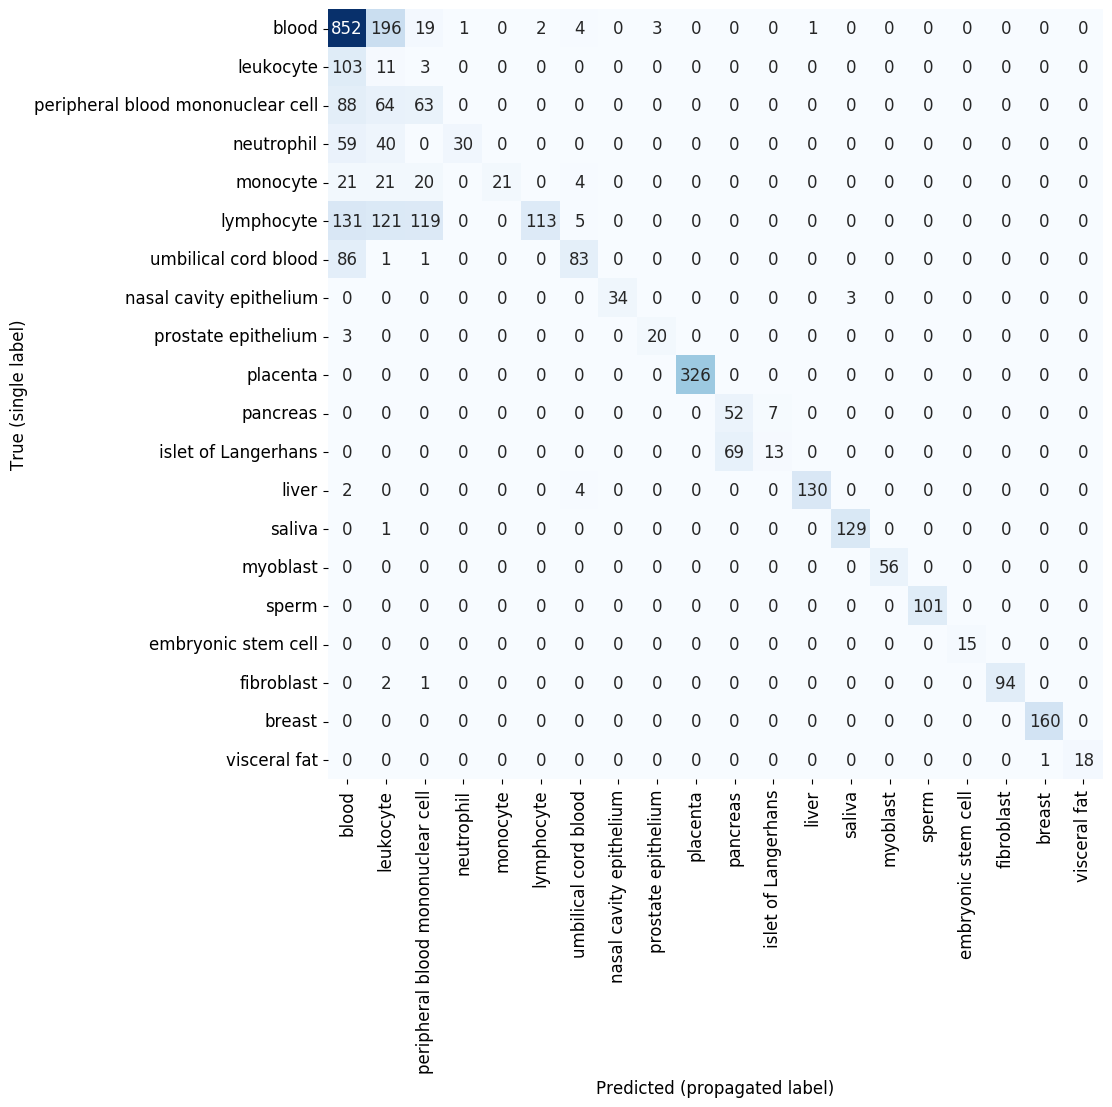

In [122]:
plt.figure(figsize=(10,10))
sns.heatmap(confmat.loc[ordered_existing][ordered_existing].astype(int), annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 12})
plt.xlabel('Predicted (propagated label)', fontsize=12)
plt.ylabel('True (single label)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./../figures/confusionmatrix_count.pdf", bbox_inches='tight')
plt.show()

In [123]:
confmat_normalized = confmat.loc[ordered_existing][ordered_existing].apply(lambda row: row / int(meta[meta['tissue_name']==row.name].shape[0]), axis=1)

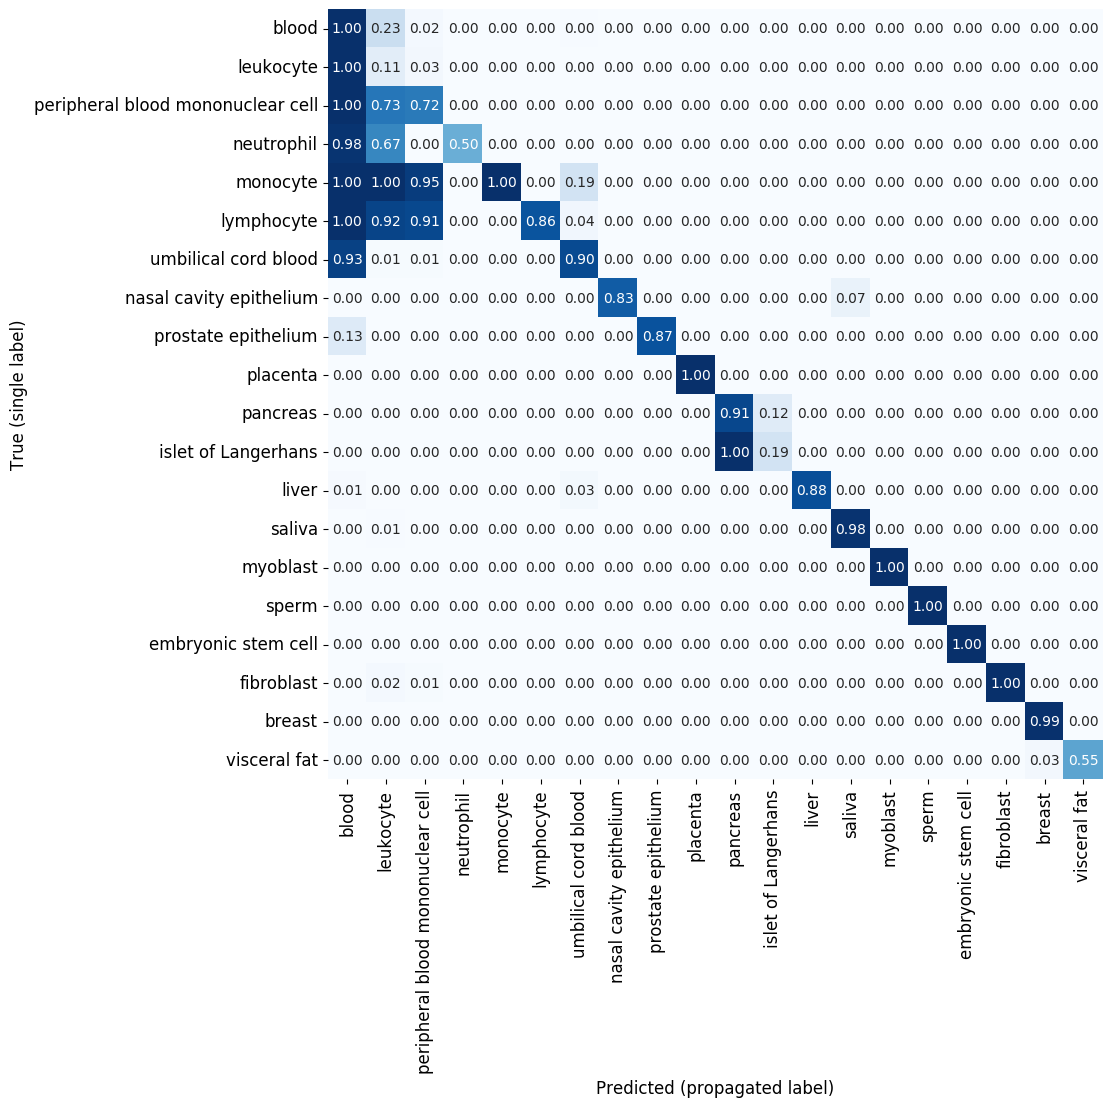

In [129]:
confmat_normalized = confmat.loc[ordered_existing][ordered_existing].apply(lambda row: row / int(meta[meta['tissue_name']==row.name].shape[0]), axis=1)

plt.figure(figsize=(10,10))
sns.heatmap(confmat_normalized, 
            annot=True, fmt='.2f', cmap='Blues', cbar=False, annot_kws={"fontsize": 10})
plt.xlabel('Predicted (propagated label)', fontsize=12)
plt.ylabel('True (single label)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./../figures/confusionmatrix_normalized.pdf", bbox_inches='tight')
plt.show()

In [132]:
save_confmat = True

if save_confmat:
    with open(f"./../figures/confmat_counts_normalized", "wb") as f:
        dill.dump([confmat.loc[ordered_existing][ordered_existing].astype(int),
                  confmat_normalized], f)

### mlcm

In [238]:
with open(f"./../workspace/mlcm_results","rb") as f:
    mlcm_cm, mlcm_ncm = dill.load(f)
    
mlcm_cm_df = pd.DataFrame(mlcm_cm, index=list(mlb.classes_)+['NTL'], columns=list(mlb.classes_)+['NPL'])
mlcm_ncm_df = pd.DataFrame(mlcm_ncm, index=list(mlb.classes_)+['NTL'], columns=list(mlb.classes_)+['NPL'])

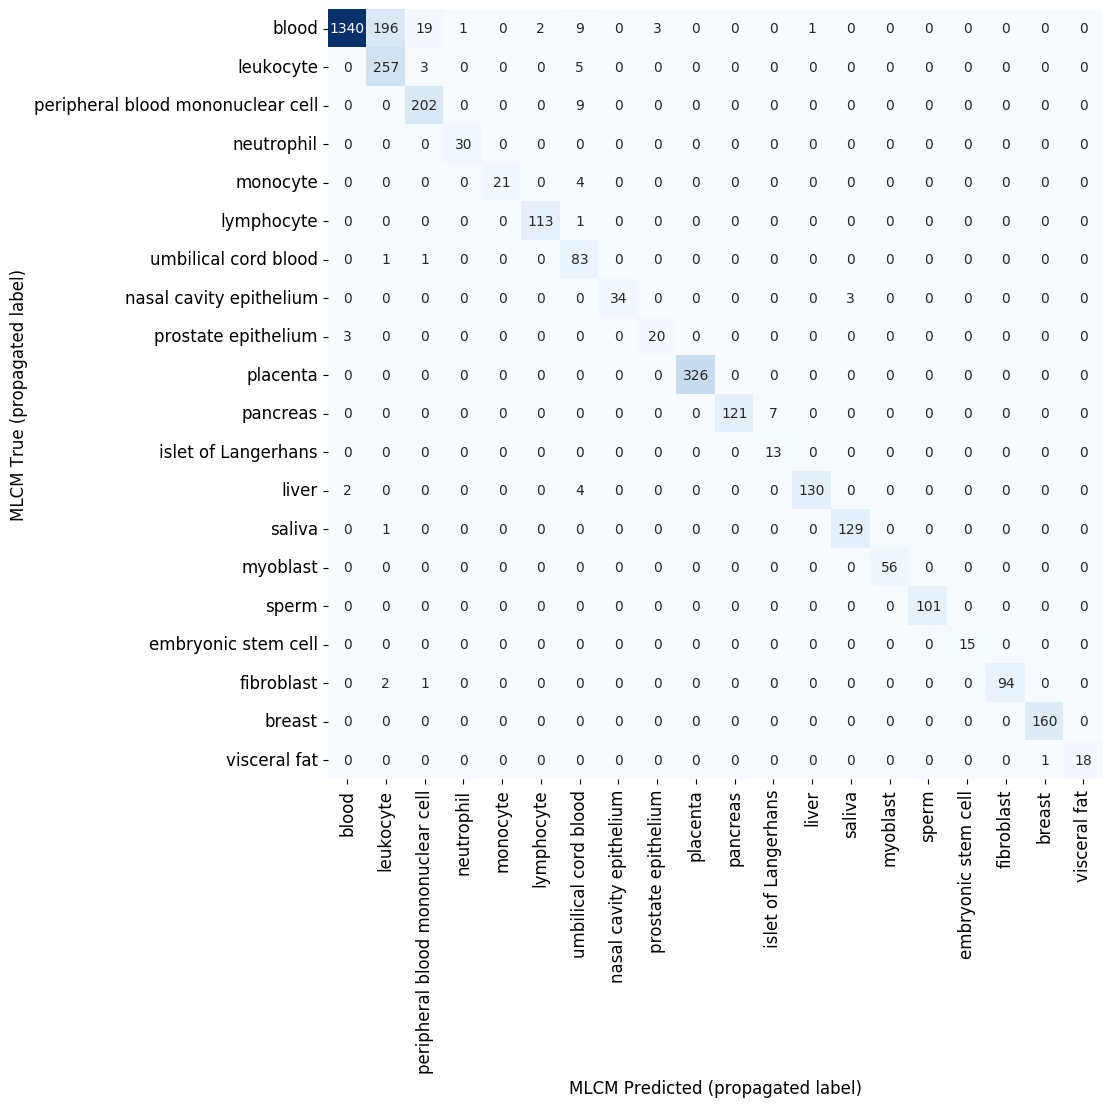

In [239]:
plt.figure(figsize=(10,10))
sns.heatmap(mlcm_cm_df.loc[ordered_existing][ordered_existing], 
            annot=True, fmt='.0f', cmap='Blues', cbar=False, annot_kws={"fontsize": 10})
plt.xlabel('MLCM Predicted (propagated label)', fontsize=12)
plt.ylabel('MLCM True (propagated label)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("./../figures/confusionmatrix_normalized.pdf", bbox_inches='tight')
plt.show()

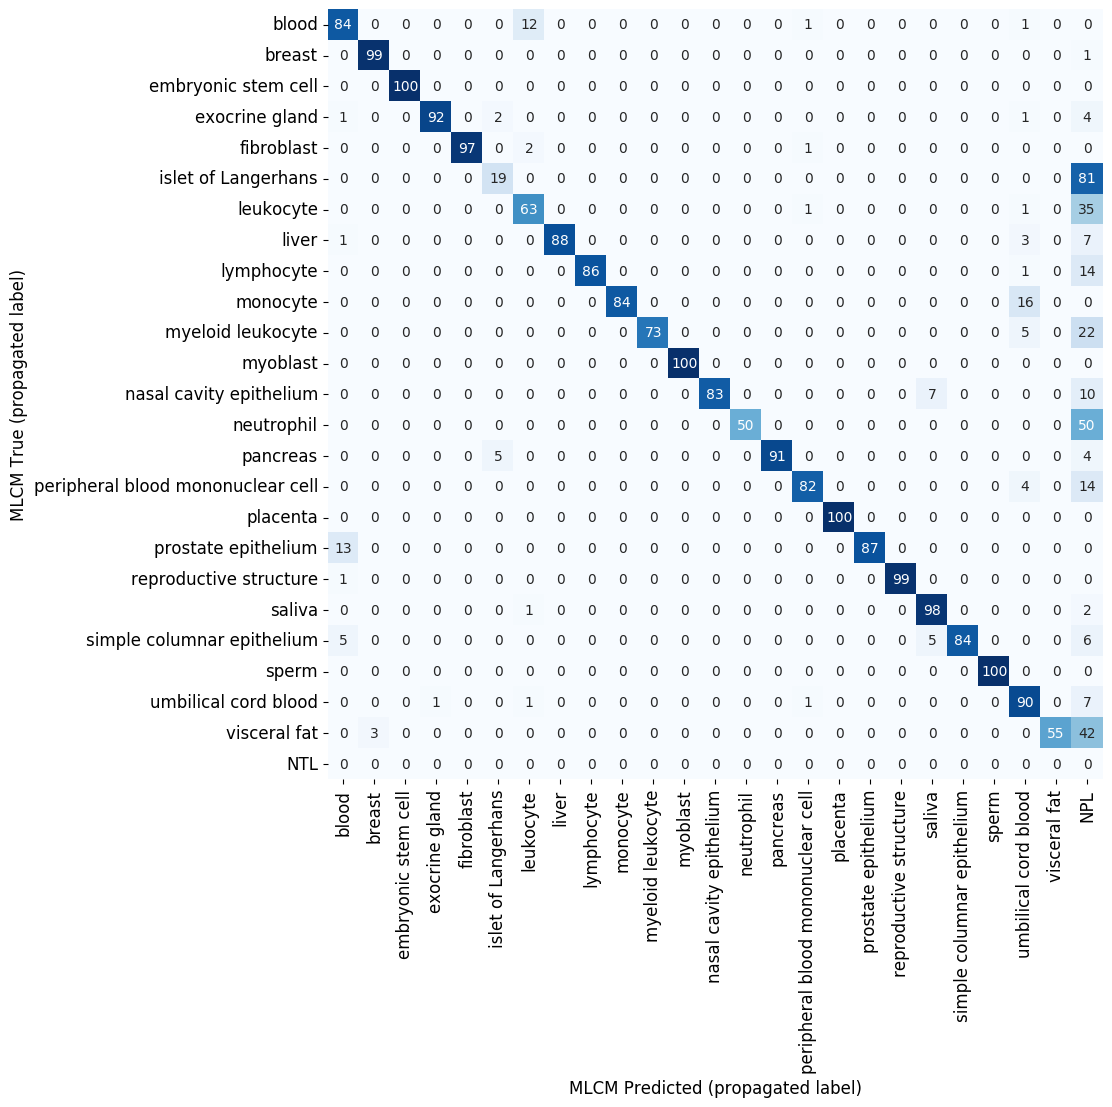

In [240]:
plt.figure(figsize=(10,10))
sns.heatmap(mlcm_ncm_df, 
            annot=True, fmt='.0f', cmap='Blues', cbar=False, annot_kws={"fontsize": 10})
plt.xlabel('MLCM Predicted (propagated label)', fontsize=12)
plt.ylabel('MLCM True (propagated label)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("./../figures/confusionmatrix_normalized.pdf", bbox_inches='tight')
plt.show()

## scatter

In [133]:
def single_to_dict(df, ordered_labels, method="accuracy"):
    df_dict = dict()
    
    for tissue in ordered_labels:
        if tissue in df['true'].values:
            tissue_true = df['true']==tissue
            tissue_pred = df['pred']==tissue

            if method=="accuracy":
                df_dict[tissue] = accuracy_score(tissue_true, tissue_pred)
            elif method=="precision":
                df_dict[tissue] = precision_score(tissue_true, tissue_pred)
        else:
            df_dict[tissue]=np.nan
         
    return df_dict

def multi_to_dict(pred_multi, true_multi, ordered_labels, method="accuracy"):
    true_cat = pd.DataFrame(mlb.transform(true_multi), columns=ordered_labels)
    pred_cat = pd.DataFrame(mlb.transform(pred_multi), columns=ordered_labels)

    cat_dict = dict()
    for tissue in ordered_labels:
        if method=="accuracy":
            cat_dict[tissue] = accuracy_score(true_cat[tissue], pred_cat[tissue])
        elif method=="precision":
            cat_dict[tissue] = precision_score(true_cat[tissue], pred_cat[tissue])
    return cat_dict

In [134]:
def plot_scatter(x_dict, y_dict, x_label = "multilabel acc", y_label = "differential methylation acc", save=False):
    x_dict = {x:y for x,y in x_dict.items() if pd.notna(y)}
    y_dict = {x:y for x,y in y_dict.items() if pd.notna(y)}
    
    dict_labels = list(sorted(set(x_dict.keys()).intersection(set(y_dict.keys()))))
    colors, ordered = get_family_colors(subtree)
    labels = [label for label in ordered if label in dict_labels]
    
    plt.figure()
    fig, ax = plt.subplots(dpi=300)

    for i, label in enumerate(labels):
        x = x_dict[label]
        y = y_dict[label]
        c = [colors[label]]
        ax.scatter(x, y,  c=c, label=label)
        # if x<0.8 or y<0.8:
        #     ax.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=5)
    plt.xlim(round(min(list(x_dict.values())+list(y_dict.values())),1)-0.01, 1.01)
    plt.ylim(round(min(list(x_dict.values())+list(y_dict.values())),1)-0.01, 1.01)
    plt.legend(loc="center left", shadow=False, scatterpoints=1, bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    line = mlines.Line2D([0, 1], [0, 1], linestyle='--', linewidth=0.5, color='grey')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    
    # Get the handles and labels of the current plot
    handles, labels = ax.get_legend_handles_labels()

    # Create the legend with two columns using plt.legend
    plt.legend(handles, labels, loc="center left", shadow=False, scatterpoints=1, bbox_to_anchor=(1, 0.5), fontsize=12, ncol=2)
    # for i, txt in enumerate(multilabel_dict.keys()):
    #     ax.annotate(txt, (x[i], y[i]))
    # plt.tight_layout()
    if save: plt.savefig(f"./../figures/scatter_{x_label}_{y_label}.pdf", bbox_inches='tight')
    plt.show()

In [135]:
minipatch_acc_dict = multi_to_dict(
    pred_res['pred'], 
    pred_res['true'], 
    mlb.classes_, 
    method="accuracy")
minipatch_prec_dict = multi_to_dict(
    pred_res['pred'], 
    pred_res['true'], 
    mlb.classes_, 
    method="precision")

In [138]:
with open("./../data/GEO/diffmeth/diffmeth_corr.pkl", "rb") as f:
    diffmeth_corr = pickle.load(f)
with open("./../data/GEO/diffmeth/diffmeth_ovr.pkl", "rb") as f:
    diffmeth_ovr = pickle.load(f)
# with open("diffmeth_union.pkl", "rb") as f:
#     diffmeth_union = pickle.load(f)
    
for sample in diffmeth_ovr.index:
    sample_prob = [p[1] if isinstance(p, tuple) else np.nan for p in diffmeth_ovr.loc[sample].values]
    diffmeth_ovr.loc[sample] = sample_prob

diffmeth_ovr['pred'] = diffmeth_ovr.astype(float).idxmax(axis=1)
diffmeth_ovr['true'] = diffmeth_corr['true']

In [139]:
# diffmeth_corr_acc_dict = single_to_dict(
#     diffmeth_corr,
#     mlb.classes_, 
#     method="accuracy")
diffmeth_corr_prec_dict = single_to_dict(
    diffmeth_corr, 
    mlb.classes_, 
    method="precision")

In [140]:
# diffmeth_ovr_acc_dict = single_to_dict(
#     diffmeth_ovr, 
#     mlb.classes_,
#     method="accuracy")
diffmeth_ovr_prec_dict = single_to_dict(
    diffmeth_ovr, 
    mlb.classes_, 
    method="precision")

['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#bcf60c', '#800000', '#008080', '#e6beff', '#f032e6', '#fabebe', '#9a6324', '#fffac8', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']


<Figure size 640x480 with 0 Axes>

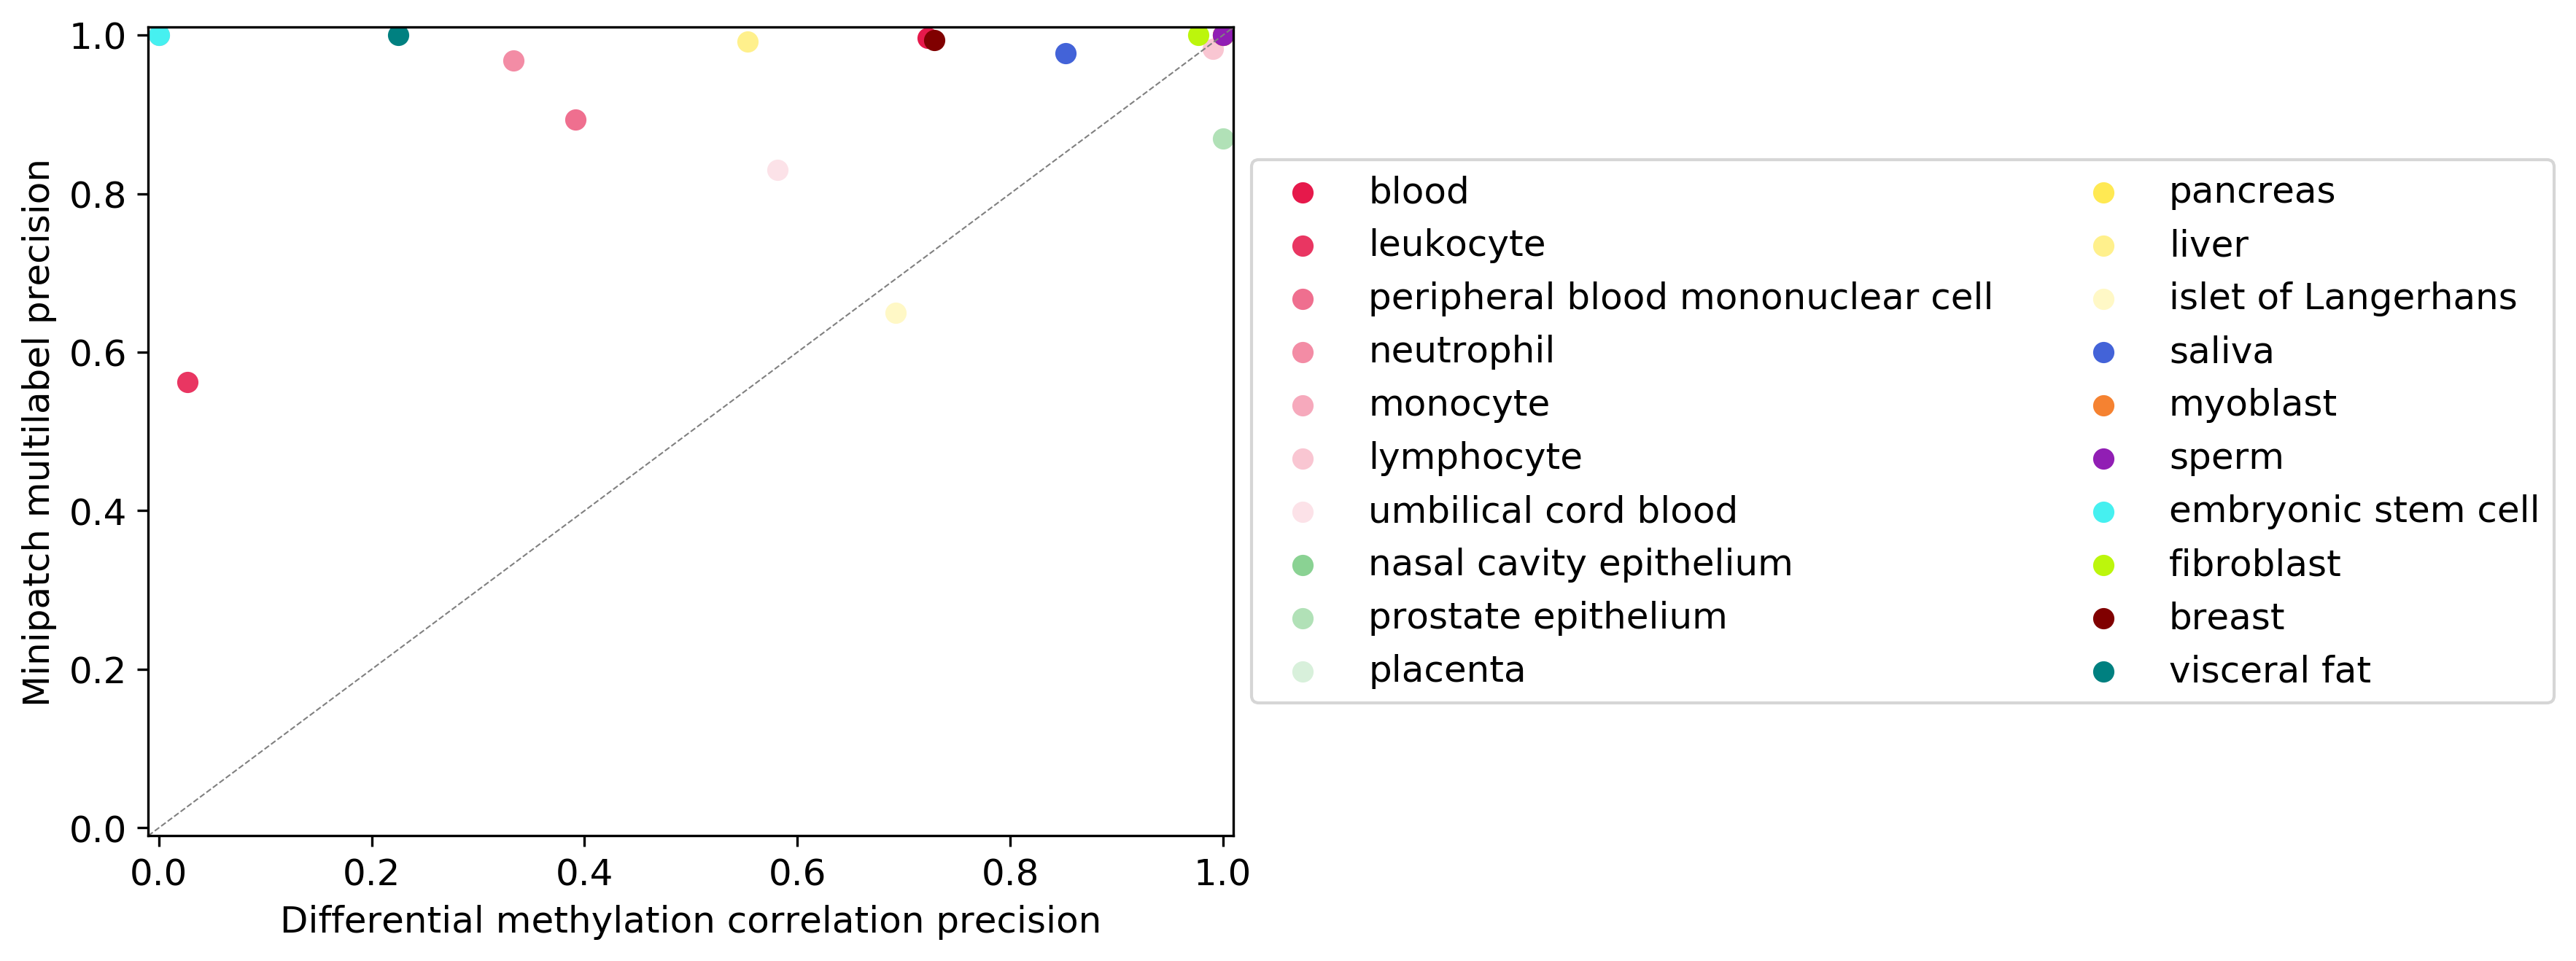

In [141]:
plot_scatter(diffmeth_corr_prec_dict, 
             minipatch_prec_dict, 
             x_label = "Differential methylation correlation precision", 
             y_label = "Minipatch multilabel precision", 
             save=True)

In [161]:
save = True

if save:
    with open(f"./../figures/scatter_diffmethcorr_minipatchmultilabel", "wb") as f:
        dill.dump([diffmeth_corr_prec_dict,minipatch_prec_dict], f)
    

['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#bcf60c', '#800000', '#008080', '#e6beff', '#f032e6', '#fabebe', '#9a6324', '#fffac8', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']


<Figure size 640x480 with 0 Axes>

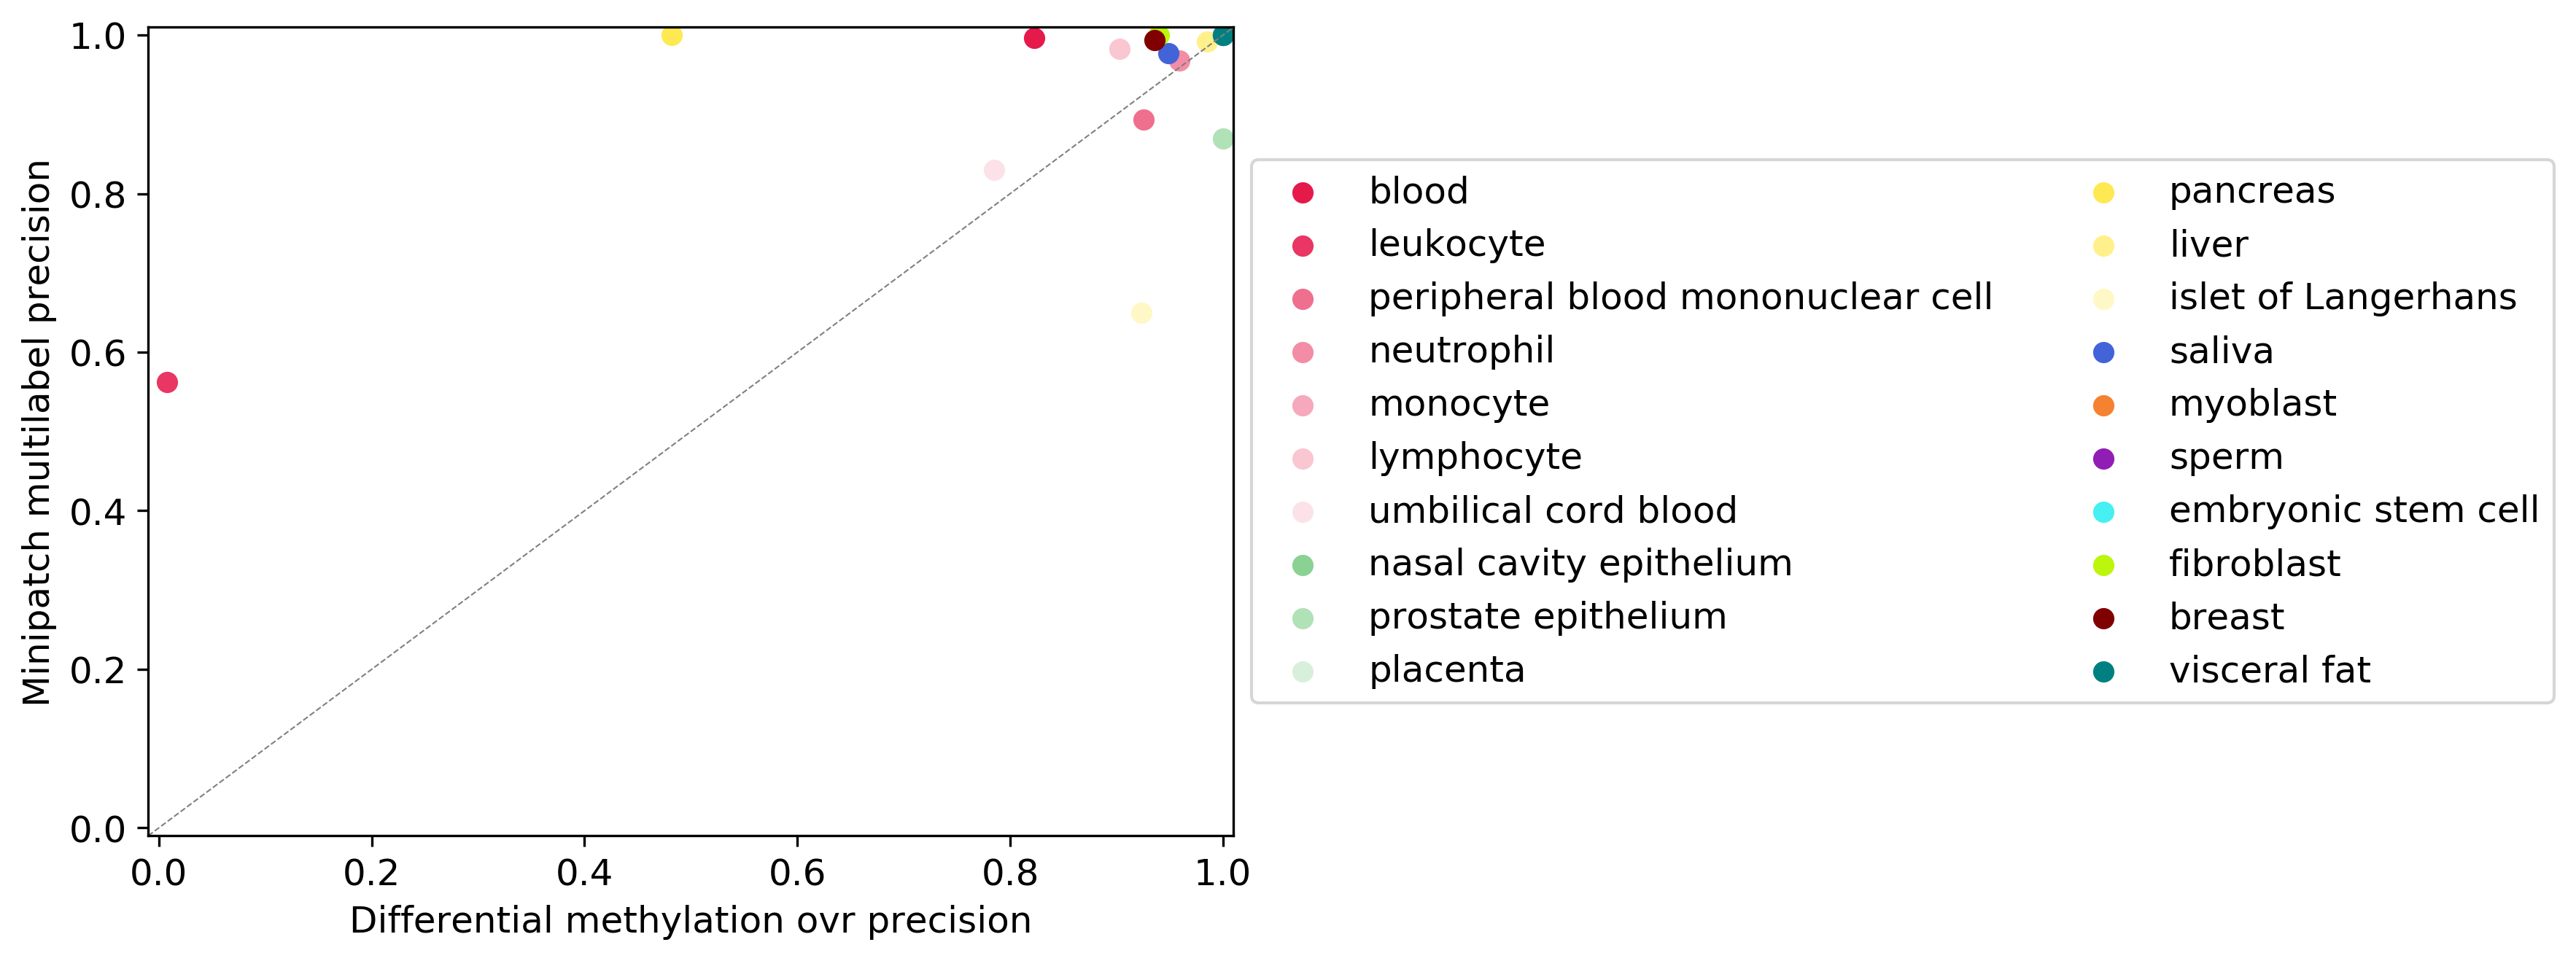

In [142]:
plot_scatter(diffmeth_ovr_prec_dict, 
             minipatch_prec_dict, 
             x_label = "Differential methylation ovr precision", 
             y_label = "Minipatch multilabel precision", 
             save=True)

In [162]:
save = True

if save:
    with open(f"./../figures/scatter_diffmethovr_minipatchmultilabel", "wb") as f:
        dill.dump([diffmeth_ovr_prec_dict,minipatch_prec_dict], f)

In [146]:
with open(f"./../data/GEO/diffmeth/diffmeth_all", "rb") as f:
    diffmeth_all = dill.load(f)

In [155]:
diffmeth_probes = dict()
for tissue, diffmeth_tissue in diffmeth_all.items():
    diffmeth_probes[tissue] = list(diffmeth_tissue[diffmeth_tissue['PValue'] < diffmeth_tissue['PValue_cutoff']].index)

In [159]:
diffmeth_union = list(set().union(*diffmeth_probes.values()))
print(f"union of all differential methylation probes: {len(diffmeth_union)}")

union of all differential methylation probes: 473460


In [160]:
diffmeth_intersection = list(set().intersection(*diffmeth_probes.values()))
print(f"intersection of all differential methylation probes: {len(diffmeth_intersection)}")

intersection of all differential methylation probes: 0


# figure 4

## histogram

In [165]:
import warnings
warnings.filterwarnings('ignore')

import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
sys.path.append('./../src/')

import utils
import dill
# dill.load_session(f'base.db')
random.seed(9)
np.random.seed(9)

date = "sep2024"
atleast = 2
with open(f"uberon_{date}_atleast{atleast}", "rb") as dill_file:
    subtree, subtree_meta, pos = dill.load(dill_file)
mlb=MultiLabelBinarizer().fit([[id_to_name[node] for node in subtree.nodes]])

In [166]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from itertools import chain

In [167]:
# get all normal data

filename = f"./../data/GEO/preprocessed/450K_Mvalues"
print(f"loading from {filename}...")
with open(filename, "rb") as dill_file:
    normal_Mv, normal_meta, island = dill.load(dill_file)

loading from ./../data/GEO/preprocessed/450K_Mvalues...


In [168]:
# avoid general terms

avoid = ['tissue','mucosa', 'appendage']

normal_meta = normal_meta[~normal_meta['tissue_name'].isin(avoid)]
normal_Mv = normal_Mv.loc[normal_meta.index]

In [169]:
# get data used in training/validation/testing

filename = f"./../data/GEO/preprocessed/450K_Mvalues_atleast2_samplewise"
print(f"loading from {filename}...")
with open(filename, "rb") as dill_file:
    mult_Mv, mult_meta, mult_island = dill.load(dill_file)

loading from ./../data/GEO/preprocessed/450K_Mvalues_atleast2_samplewise...


In [170]:
# get those not in training/validation/testing
# scale as single_Mv_scaled

single_Mv = normal_Mv.loc[normal_Mv.index.difference(mult_Mv.index)][mult_Mv.columns]
single_meta = normal_meta.loc[single_Mv.index]

print(single_Mv.shape)
print(single_meta.shape)

single_meta = single_meta[~single_meta['tissue_name'].isin(list(set(single_meta['tissue_name']) & set(mult_meta['tissue_name'])))]
single_Mv = single_Mv.loc[single_meta.index]

scaler = StandardScaler().fit(single_Mv.transpose().values)
single_Mv_scaled = scaler.transform(single_Mv.transpose().values)
single_Mv_scaled = pd.DataFrame(single_Mv_scaled.transpose(), index=single_Mv.index, columns=single_Mv.columns)

print(single_Mv_scaled.shape)
print(single_meta.shape)

(578, 473821)
(578, 7)
(566, 473821)
(566, 7)


In [171]:
# get zero tree

with open(f"uberon_{date}_atleast{atleast}_zero", "rb") as dill_file:
    zero_tree, zero_pos = dill.load(dill_file)

In [172]:
Mv_all, meta_all, mapping_all = dill.load(open(f'./../data/GEO/preprocessed/450K_Mvalues_atleast{atleast}_samplewise', 'rb'))

meta_multi = utils.propagate_parent(subtree, meta_all, outdict=False)
meta_mlb = mlb.transform(meta_multi['tissue_name'].values)

filename = "_whole"
minipatch_location = f"./../data/GEO/minipatch/minipatch{filename}_selector"
print(f"loading minipatch selector from {minipatch_location}")
fitted_selector = dill.load(open(minipatch_location, 'rb'))

selection_frequency_threshold = 0.57
selection_freq = pd.DataFrame(fitted_selector.Pi_hat_last_k_, index=mult_Mv.columns)
minipatch_probes = list(selection_freq[selection_freq[0]>=selection_frequency_threshold].index)
Mv = mult_Mv[minipatch_probes]

with open(f"./../data/GEO/minipatch/multilabel{filename}_clf", 'rb') as f:
    clf = pickle.load(f)

tissue_to_clf = {t:c for t,c in zip(mlb.classes_, clf.estimators_)}

loading minipatch selector from ./../data/GEO/minipatch/minipatch_whole_selector


In [173]:
avoid = ['tissue','mucosa', "appendage"]

single_Mv_minipatch = single_Mv_scaled[Mv45.columns]

single_meta = single_meta[~single_meta['tissue_name'].isin(avoid)]
single_Mv_minipatch = single_Mv_minipatch.loc[single_meta.index]

In [174]:
pred_proba_list = clf.predict_proba(single_Mv_minipatch)
pred_proba_df = pd.DataFrame(index=single_meta.index, columns=mlb.classes_)
for i, tissue in enumerate(mlb.classes_):
    pred_proba_df[tissue] = pred_proba_list[i][:,1]
pred_proba_df

,blood,breast,embryonic stem cell,exocrine gland,fibroblast,islet of Langerhans,leukocyte,liver,lymphocyte,monocyte,...,pancreas,peripheral blood mononuclear cell,placenta,prostate epithelium,reproductive structure,saliva,simple columnar epithelium,sperm,umbilical cord blood,visceral fat
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1484233,1.007549e-04,0.029226,0.000827,0.000585,0.000271,0.003169,1.000000e-07,0.000049,6.442251e-04,0.000004,...,0.002588,3.778761e-03,0.002325,0.000097,0.001806,0.000008,0.000159,0.000326,1.955302e-05,0.006331
GSM1484235,1.188029e-03,0.129030,0.000799,0.000709,0.000293,0.000235,1.000000e-07,0.000034,1.105576e-04,0.000005,...,0.005736,7.428874e-04,0.001250,0.000022,0.000299,0.000004,0.000034,0.000312,5.659187e-05,0.004171
GSM1484237,4.129988e-05,0.099537,0.000642,0.001014,0.000342,0.000158,1.000000e-07,0.000045,1.584112e-04,0.000004,...,0.006200,1.286715e-03,0.001448,0.000167,0.001582,0.000013,0.000093,0.000291,8.386523e-06,0.010573
GSM1484239,8.222504e-05,0.020243,0.000737,0.001400,0.000319,0.000428,1.000000e-07,0.000039,1.122905e-04,0.000005,...,0.006763,7.176085e-03,0.001186,0.000157,0.001710,0.000010,0.000111,0.000261,9.709385e-06,0.005496
GSM1484241,4.299742e-04,0.099908,0.000734,0.000891,0.000183,0.000178,1.000000e-07,0.000044,3.323891e-04,0.000005,...,0.006518,2.308792e-03,0.001703,0.000061,0.000824,0.000003,0.000083,0.000318,8.590463e-06,0.004648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM5384604,9.093618e-04,0.011935,0.000748,0.071320,0.000167,0.000019,3.072098e-03,0.000752,2.888102e-07,0.000020,...,0.055153,2.544081e-06,0.000502,0.000020,0.000027,0.000883,0.000926,0.000280,1.000000e-07,0.000049
GSM5384608,3.346807e-07,0.036446,0.000895,0.009102,0.000805,0.000086,1.000000e-07,0.000105,1.718984e-05,0.000002,...,0.026701,1.000000e-07,0.000453,0.000655,0.000836,0.000007,0.871141,0.000362,1.000000e-07,0.000029
GSM5384610,1.000000e-07,0.093342,0.001471,0.000884,0.000491,0.038008,6.446301e-07,0.000034,1.000000e-07,0.000003,...,0.003611,1.000000e-07,0.000493,0.000056,0.000075,0.038671,0.002811,0.000513,1.000000e-07,0.000034


In [175]:
pred = clf.predict(single_Mv_minipatch)
true = single_meta['tissue_name']

In [176]:
def get_distance(g, n, n_type="name", display=False):
    if isinstance(g, nx.MultiDiGraph): 
        print("ERROR: g must be undirected")
        return
    
    if n_type=="name":
        n[0]=name_to_id[n[0]]
        n[1]=name_to_id[n[1]]

    try:
        distance = nx.shortest_path_length(g, source=n[0], target=n[1])
        if not isinstance(distance, int): print(f"{name_to_id[n[0]], name_to_id[n[1]], distance}")
        return distance
    except Exception:
        if display: print(f"{id_to_name[n[0]]} and {id_to_name[n[1]]}: no distance")
        return np.nan

In [177]:
zero_tree_undirected = nx.MultiGraph(zero_tree)

sample_ave_distance = pd.Series(index=pred_proba_df.index)
for idx, row in pred_proba_df.iterrows():
    pos_pred = list(row[row>0.50].index)
    if len(pos_pred)==0:
        # pos_pred = list(row.nlargest(1).index) #pick top1 if no prediction
        continue # do not predict if not sure
    
    pred_distances = [get_distance(zero_tree_undirected, [true.loc[idx], pred], n_type="name", display=False) for pred in pos_pred]
    sample_ave_distance[idx] = np.mean(pred_distances)

In [178]:
distances_per_tissue = dict()
for tissue in np.unique(true.values):
    distances_per_tissue[tissue] = sample_ave_distance[list(single_meta[single_meta['tissue_name']==tissue].index)].values.tolist()

In [179]:
# get zero tree prediction distances

# with open(f"distances_per_tissue", "rb") as dill_file:
#     distances_per_tissue = dill.load(dill_file)

In [180]:
# zero-shot predictions with values

zero_tissues_all = set(distances_per_tissue.keys())
print(f"zero tissues: {len(zero_tissues_all)}")

zero_meta_all = normal_meta[normal_meta['tissue_name'].isin(zero_tissues_all)]
print(f"zero tissues not in subtree: {len(zero_meta_all.tissue_name.unique())}")
print(f"series with zero tissues and not in subtree: {len(zero_meta_all.series.unique())}")
print(f"samples with zero tissues and not in subtree: {zero_meta_all.shape[0]}")

zero tissues: 49
zero tissues not in subtree: 49
series with zero tissues and not in subtree: 39
samples with zero tissues and not in subtree: 566


In [181]:
# zero-shot predictions with values but not in subtree

zero_tissues = zero_tissues_all-set([id_to_name[node] for node in subtree.nodes])
print(f"labels with predictions and not in subtree: {len(zero_tissues)}")

zero_meta = normal_meta[normal_meta['tissue_name'].isin(zero_tissues)]
print(f"tissues with predictions and not in subtree: {len(zero_meta.tissue_name.unique())}")
print(f"series with predictions and not in subtree: {len(zero_meta.series.unique())}")
print(f"samples with predictions and not in subtree: {zero_meta.shape[0]}")

labels with predictions and not in subtree: 49
tissues with predictions and not in subtree: 49
series with predictions and not in subtree: 39
samples with predictions and not in subtree: 566


In [182]:
# number of nodes in subtree

len([id_to_name[node] for node in subtree.nodes])

24

In [183]:
# number of tissues in mult

len(mult_meta['tissue_name'].unique())

20

In [184]:
# number of all labels, samples, and series

all_tissues = set(zero_meta.tissue_name.unique()).union(set([id_to_name[node] for node in subtree.nodes]))
print(f"zero labels + subtree labels: {len(all_tissues)}")

all_meta = normal_meta[normal_meta['tissue_name'].isin(all_tissues)]
print(f"all meta labels: {len(all_meta.tissue_name.unique())}")
print(f"labels in total but with not all meta: {set(all_tissues) - set(all_meta.tissue_name.unique())}")
print(f"all meta studies: {len(all_meta.series.unique())}")
print(f"all meta samples: {all_meta.shape[0]}")

zero labels + subtree labels: 73
all meta labels: 69
labels in total but with not all meta: {'simple columnar epithelium', 'myeloid leukocyte', 'reproductive structure', 'exocrine gland'}
all meta studies: 124
all meta samples: 3182


In [185]:
# number of train labels, samples, and series

print(f"mult meta labels: {len(mult_meta.tissue_name.unique())}")
print(f"mult meta studies: {len(mult_meta.series.unique())}")
print(f"mult meta samples: {mult_meta.shape[0]}")

mult meta labels: 20
mult meta studies: 87
mult meta samples: 2604


In [186]:
keep = set(all_meta.index) - (set(all_meta.index) - set(mult_meta.index) - set(zero_meta_all.index))
all_meta_without = all_meta.loc[keep]
all_meta_without.shape

(3170, 7)

In [187]:
set(all_meta['tissue_name'].unique()) and set(mult_meta['tissue_name'].unique()) 

{'blood',
 'breast',
 'embryonic stem cell',
 'fibroblast',
 'islet of Langerhans',
 'leukocyte',
 'liver',
 'lymphocyte',
 'monocyte',
 'myoblast',
 'nasal cavity epithelium',
 'neutrophil',
 'pancreas',
 'peripheral blood mononuclear cell',
 'placenta',
 'prostate epithelium',
 'saliva',
 'sperm',
 'umbilical cord blood',
 'visceral fat'}

In [188]:
# get zero tree prediction distances

# with open(f"zeroshot_preds", "rb") as dill_file:
#     pred_proba_df, single_meta = dill.load(dill_file)

In [189]:
## filter out tissues that don't have predictions
print(len(distances_per_tissue))
for tissue in np.unique(true.values):
    if np.all(np.isnan(distances_per_tissue[tissue])): distances_per_tissue.pop(tissue)
print(len(distances_per_tissue))

49
17


In [190]:
# get distances_per_tissue

# with open(f"distances_per_tissue", "rb") as dill_file:
#     distances_per_tissue = dill.load(dill_file)

In [191]:
min_distances = dict()
pred_minus_min = dict()
df = pd.DataFrame(columns=['tissue', 'sample_or_random', 'distance'])
# pred_distances['random'] = [x for x in random_distances if pd.notna(x)]
for tissue in distances_per_tissue.keys():
    tissue_df = pd.DataFrame(columns=['tissue', 'sample_or_random', 'distance'])
    tissue_random = [
        get_distance(zero_tree_undirected, 
                     [name_to_id[tissue], 
                      random.sample(subtree.nodes, 1)[0]
                     ], 
                     n_type="id"
                    ) 
        for i in range(1000)
    ]
    min_distances[tissue] = np.nanmin([get_distance(zero_tree_undirected, [tissue, ours], n_type="name")
                                 for ours in [id_to_name[node] for node in subtree.nodes]])
    # print(f"{tissue}: {min_distances[tissue]}")
    
    dist = [dist-min_distances[tissue] for dist in distances_per_tissue[tissue]]
    dist_label = ["sample" for _ in dist]
    rand = [dist-min_distances[tissue] for dist in tissue_random]
    rand_label = ["random" for _ in rand]
    
    tissue_df['distance'] = dist+rand
    tissue_df['sample_or_random'] = dist_label+rand_label
    tissue_df['tissue'] = tissue
    
    df = pd.concat([df, tissue_df])

In [194]:
from collections import Counter

In [195]:
def combine_dicts(dict1, dict2):
    combined_dict = {}
    
    # Add values from dict1
    for key, value in dict1.items():
        combined_dict[key] = [value] + [dict2.get(key, 0)]
    
    # Add values from dict2
    for key, value in dict2.items():
        if key not in combined_dict:
            combined_dict[key] = [0, value]
    
    return combined_dict

def list_to_bin_dict(test_df, tissue, display=False):
    result=list()
    
    for category in ["sample", "random"]:
        test_list = test_df[(test_df['tissue'].isin(tissue)) & (test_df['sample_or_random']==category)]['distance'].values.tolist()
        test_list = [x for x in test_list if x is not None and not np.isnan(x)]
        
        if len(set(test_list))==1:
            result.append({round(test_list[0]):1})
        else:
            rounded_data = [round(d) for d in test_list]
            result.append({num: count / len(rounded_data) for num, count in  dict(Counter(rounded_data)).items()})
        
        if display:
            print(category)
            print(test_list)
            # print(rounded_data)
            # print(counts)
            # print(bin_locations)
        
    return combine_dicts(result[0], result[1])

list_to_bin_dict(df, ["umbilical vein"], display=True)

sample
[2.5, 2.5, 2.5, 2.5]
random
[2.0, 4.0, 4.0, 2.0, 6.0, 4.0, 6.0, 3.0, 1.0, 6.0, 6.0, 3.0, 6.0, 6.0, 3.0, 0.0, 6.0, 3.0, 3.0, 3.0, 0.0, 6.0, 1.0, 3.0, 2.0, 0.0, 3.0, 4.0, 2.0, 4.0, 5.0, 1.0, 2.0, 3.0, 4.0, 4.0, 1.0, 1.0, 4.0, 5.0, 2.0, 3.0, 2.0, 3.0, 0.0, 4.0, 3.0, 3.0, 4.0, 5.0, 1.0, 2.0, 1.0, 6.0, 1.0, 3.0, 6.0, 3.0, 4.0, 2.0, 3.0, 5.0, 4.0, 2.0, 2.0, 5.0, 6.0, 3.0, 4.0, 3.0, 3.0, 6.0, 0.0, 2.0, 2.0, 3.0, 1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 0.0, 1.0, 4.0, 3.0, 3.0, 2.0, 3.0, 5.0, 3.0, 5.0, 4.0, 6.0, 3.0, 4.0, 4.0, 3.0, 3.0, 1.0, 4.0, 4.0, 3.0, 3.0, 5.0, 4.0, 5.0, 6.0, 3.0, 5.0, 2.0, 3.0, 5.0, 2.0, 3.0, 3.0, 1.0, 5.0, 1.0, 4.0, 1.0, 5.0, 0.0, 2.0, 3.0, 3.0, 6.0, 5.0, 4.0, 3.0, 4.0, 3.0, 3.0, 3.0, 4.0, 2.0, 4.0, 3.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 0.0, 5.0, 3.0, 1.0, 3.0, 3.0, 4.0, 4.0, 3.0, 2.0, 2.0, 3.0, 0.0, 4.0, 5.0, 1.0, 1.0, 3.0, 5.0, 3.0, 3.0, 4.0, 3.0, 3.0, 5.0, 5.0, 3.0, 6.0, 3.0, 3.0, 3.0, 4.0, 1.0, 3.0, 3.0, 3.0, 5.0, 4.0, 2.0, 6.0, 4.0, 4.0, 2.0, 6.0, 5.0, 1.0, 5.0,

{2: [1, 0.10372340425531915],
 4: [0, 0.21941489361702127],
 6: [0, 0.08909574468085106],
 3: [0, 0.3071808510638298],
 1: [0, 0.10638297872340426],
 0: [0, 0.05585106382978723],
 5: [0, 0.11835106382978723]}

In [196]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

In [197]:
labels = ['sample','random']
annot_pairs = [((tissue, labels[0]), (tissue, labels[1])) for tissue in df['tissue'].unique()]

combinations_p = list()
for (tissue1, sample1), (tissue1, random1) in annot_pairs:
    data1 = df[(df['tissue'] == tissue1) & (df['sample_or_random'] == sample1)]['distance']
    data1 = data1[data1.notna()]
    data2 = df[(df['tissue'] == tissue1) & (df['sample_or_random'] == random1)]['distance']
    data2 = data2[data2.notna()]
    # Significance
    U, p = mannwhitneyu(data1, data2, alternative="less")
    
    combinations_p.append([(tissue1, sample1), p])
        
rejected, p_adjusted = fdrcorrection([pv for comb, pv in combinations_p])
significant_combinations = [(comb, p_adj) for comb, p_adj in zip(annot_pairs, p_adjusted) 
                            if p_adj<0.05]
tissue_to_pv = {comb[0][0]: p_adj for comb, p_adj in zip(annot_pairs, p_adjusted)}

tissue_to_pv

{'bronchus': 1.500259802374199e-07,
 'chorionic villus': 0.9997361847373266,
 'colon': 0.08411015570780837,
 'duodenum': 0.25320968687804013,
 'fallopian tube': 0.5819729275165978,
 'gastric gland': 1.6549617374736906e-19,
 'granulocyte': 0.06852629185551586,
 'intestinal mucosa': 0.01292332119463198,
 'intestine': 0.011001251579331172,
 'larynx': 0.08159431371689972,
 'macrophage': 0.019966287890904027,
 'rectum': 0.021903063102901098,
 'small intestine': 0.08159431371689972,
 'stomach': 3.540294821669007e-05,
 'thymus': 0.07330243621487868,
 'trachea': 2.1074522723455134e-09,
 'umbilical vein': 0.07622307975288074}

In [198]:
# Sort labels based on pvalue
sorted_labels = [x for x in sorted(df['tissue'].unique(), key=lambda x: tissue_to_pv[x]) if x not in [id_to_name[y] for y in subtree.nodes]]
sorted_labels

['gastric gland',
 'trachea',
 'bronchus',
 'stomach',
 'intestine',
 'intestinal mucosa',
 'macrophage',
 'rectum',
 'granulocyte',
 'thymus',
 'umbilical vein',
 'larynx',
 'small intestine',
 'colon',
 'duodenum',
 'fallopian tube',
 'chorionic villus']

In [200]:
# Extract y positions for each node
node_positions = {node: zero_pos[node][1] for node in zero_tree.nodes()}

# Sort nodes based on y positions
sorted_nodes = sorted(zero_tree.nodes(), key=lambda n: node_positions[n], reverse=True)

print([id_to_name[x] for x in sorted_nodes])


['reproductive system', 'vascular system', 'digestive system', 'alimentary part of gastrointestinal system', 'reproductive structure', 'musculature', 'digestive tract', 'blood vessel', 'arterial system', 'pelvic complex', 'female reproductive system', 'smooth muscle tissue', 'musculature of pelvic complex', 'endocrine system', 'gut wall', 'pelvic appendage', 'skeletal muscle organ', 'respiratory system', 'gastrointestinal system mucosa', 'arterial blood vessel', 'food storage organ', 'oviduct', 'reproductive organ', 'foregut', 'placenta', 'venous blood vessel', 'male reproductive gland', 'appendage musculature', 'intestine', 'internal genitalia', 'lower respiratory tract', 'musculature of limb', 'stomach', 'hematopoietic system', 'respiratory system smooth muscle', 'mixed endoderm/mesoderm-derived structure', 'gland of foregut', 'pelvic appendage musculature', 'large intestine', 'immune system', 'umbilical vein', 'respiratory airway', 'small intestine', 'female reproductive organ', 'en

In [201]:
# all_nodes = [name_to_id[x] for x in single_meta['tissue_name'].unique()]
all_nodes = [name_to_id[x] for x in distances_per_tissue.keys()]
# sorted_nodes = [name_to_id[x] for x in ['digestive system', 'musculature of body', 'epithelium', 'nervous system', 
#                'reproductive system', 'respiratory system', 'cardiovascular system', 
#                'hematopoietic system', 'abdominal segment of trunk', 'embryo']]

node_groups = dict()
for big_node in sorted_nodes:
    big_children = nx.ancestors(zero_tree, big_node)
    if len(big_children)==0: continue
    
    if 'epithelium' in id_to_name[big_node]: 
        big_children_in_nodes =  [node for node in all_nodes if node in big_children]
    else: 
        big_children_in_nodes = [node for node in all_nodes if ((node in big_children) and ('epithelium' not in id_to_name[node]))]
    if len(big_children_in_nodes)==0: continue
    
    all_nodes = list(set(all_nodes) - set(big_children_in_nodes))
    node_groups[id_to_name[big_node]] = [id_to_name[x] for x in big_children_in_nodes]
    
    if len(all_nodes)==0: break
node_groups

{'reproductive system': ['fallopian tube'],
 'vascular system': ['umbilical vein'],
 'digestive system': ['intestine',
  'intestinal mucosa',
  'rectum',
  'gastric gland',
  'duodenum',
  'colon',
  'small intestine',
  'stomach'],
 'endocrine system': ['thymus'],
 'respiratory system': ['trachea', 'bronchus', 'larynx'],
 'hematopoietic system': ['granulocyte', 'macrophage'],
 'embryo': ['chorionic villus']}

In [202]:
def survey_zero(results, category_names, tissue=None, ax=None):
    """
    """
    neg_xlim = 1
    pos_xlim = 0.3
    
    results = dict(sorted(results.items()))
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data[:,0] = data[:,0]/neg_xlim
    data[:,1] = data[:,1]/pos_xlim
    data_cum = data.cumsum(axis=1)
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    if ax is None:
        ax = plt.subplot()
    else:
        ax = ax
        
    ax.set_xlim(-neg_xlim, pos_xlim)
    ax.set_xticks([-1, 0, 1])
    ax.set_xticklabels([1, 0, 0.3])


    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        offsets = data[:, 0]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.9,
                        label=colname, color=color)
    
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

    return ax

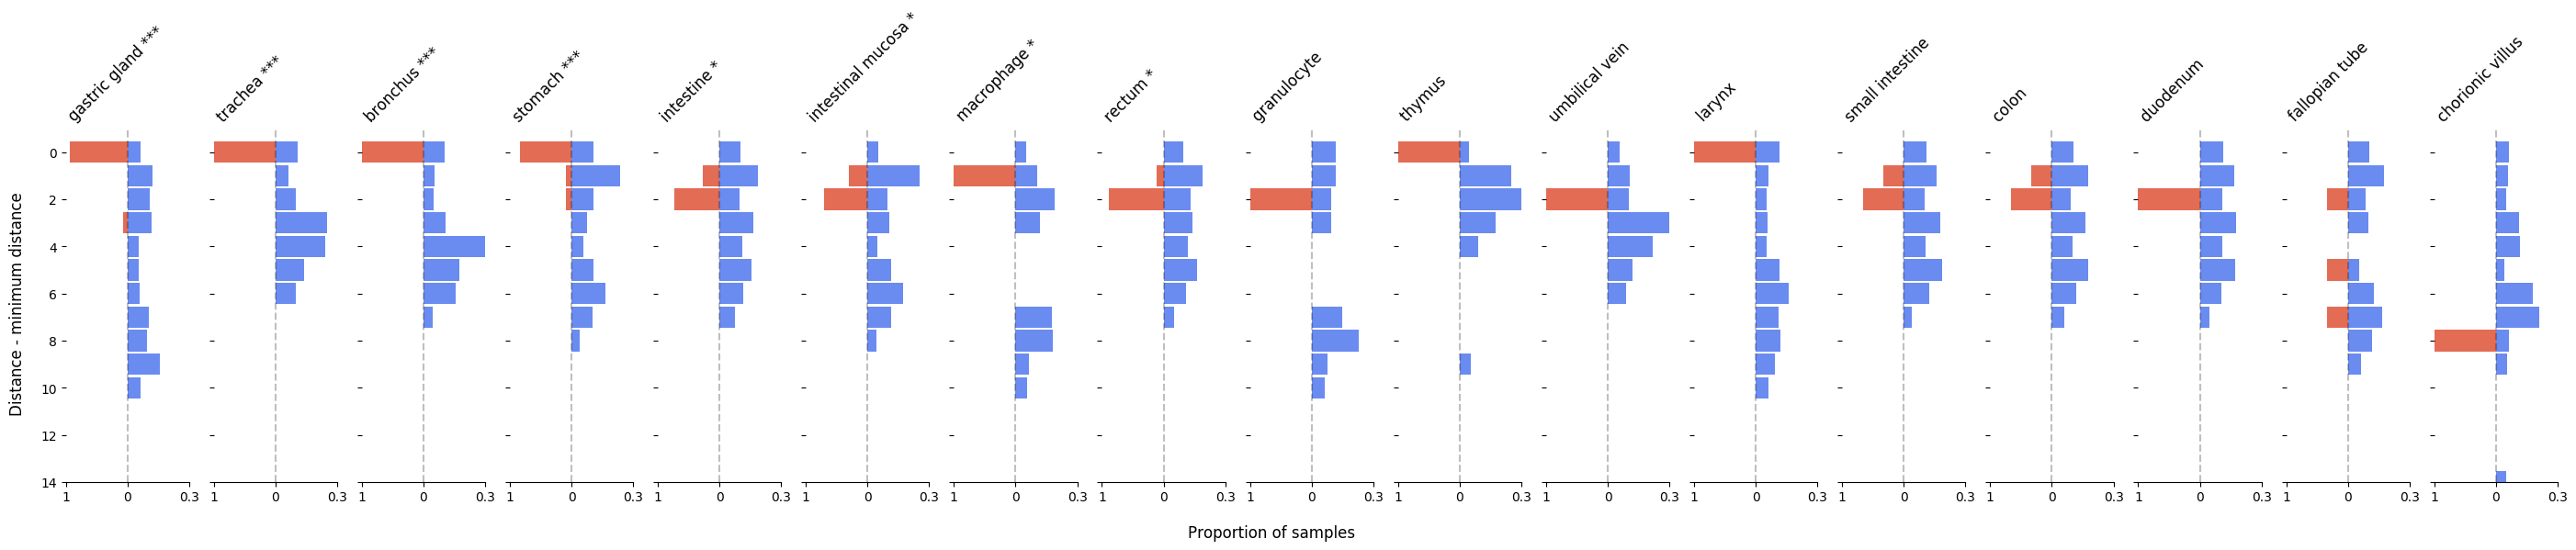

In [204]:
fig, ax = plt.subplots(1, len(df['tissue'].unique()), sharey=True, figsize=(35,5))

for i, tissue in enumerate(sorted_labels):
    ax[i].set_ylim(14, -1)
    ax[i] = survey_zero(list_to_bin_dict(df,[tissue]), 'sample_or_random', [tissue], ax[i])
    if tissue_to_pv[tissue]<0.001:
        sig="***"
    elif tissue_to_pv[tissue]<0.01:
        sig="**"
    elif tissue_to_pv[tissue]<0.05:
        sig="*"
    else:
        sig=""
    ax[i].set_title(f"{tissue} {sig}", rotation = 45, loc='left')
    # ax[i].set_title(f"{tissue}", rotation = 45, loc='left')
    
fig.text(0.5, 0, 'Proportion of samples', ha='center', va='center', fontsize=12)
fig.text(0.11, 0.5, 'Distance - minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)

plt.savefig("./../figures/zeroshot_hist.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [205]:
labels = ['sample','random']
annot_pairs = [((tissue, labels[0]), (tissue, labels[1])) for tissue in node_groups.keys()]

combinations_p = list()
for (tissue1, sample1), (tissue1, random1) in annot_pairs:
    data1 = df[(df['tissue'].isin(node_groups[tissue1])) & (df['sample_or_random'] == sample1)]['distance']
    data1 = data1[data1.notna()]
    data2 = df[(df['tissue'].isin(node_groups[tissue1])) & (df['sample_or_random'] == random1)]['distance']
    data2 = data2[data2.notna()]
    # Significance
    U, p = mannwhitneyu(data1, data2, alternative="less")
    
    combinations_p.append([(tissue1, sample1), p])
        
rejected, p_adjusted = fdrcorrection([pv for comb, pv in combinations_p])
significant_combinations = [(comb, p_adj) for comb, p_adj in zip(annot_pairs, p_adjusted) 
                            if p_adj<0.05]
group_to_pv = {comb[0][0]: p_adj for comb, p_adj in zip(annot_pairs, p_adjusted)}

group_to_pv

{'reproductive system': 0.6390290968809702,
 'vascular system': 0.06904914283496255,
 'digestive system': 6.2746921627813054e-27,
 'endocrine system': 0.06904914283496255,
 'respiratory system': 1.414348933642103e-16,
 'hematopoietic system': 0.0047657102681095045,
 'embryo': 0.9997361847373266}

In [206]:
sorted_groups = [x for x in sorted(node_groups.keys(), key=lambda x: group_to_pv[x])]
sorted_groups

['digestive system',
 'respiratory system',
 'hematopoietic system',
 'vascular system',
 'endocrine system',
 'reproductive system',
 'embryo']

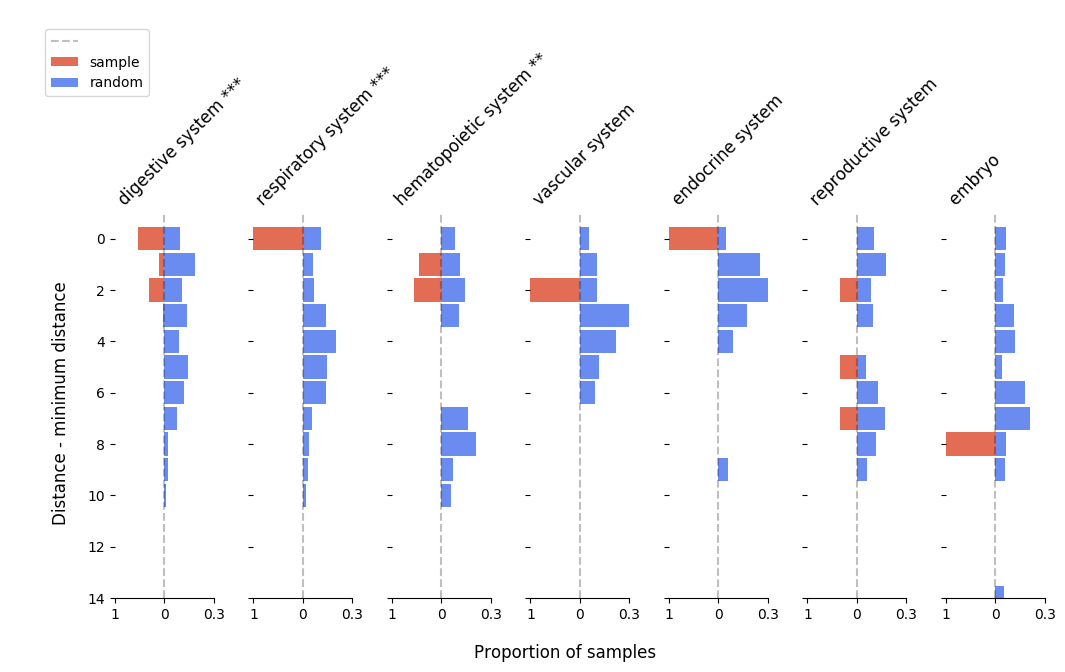

In [207]:
fig, ax = plt.subplots(1, len(node_groups.keys()), sharey=True, figsize=(12,5))

for i, tissue in enumerate(sorted_groups):
    ax[i].set_ylim(14, -1)
    ax[i] = survey_zero(list_to_bin_dict(df, node_groups[tissue]), 'sample_or_random', node_groups[tissue], ax[i])
    if group_to_pv[tissue]<0.001:
        sig="***"
    elif group_to_pv[tissue]<0.01:
        sig="**"
    elif group_to_pv[tissue]<0.05:
        sig="*"
    else:
        sig=""
    ax[i].set_title(f"{tissue} {sig}", rotation = 45, loc='left')
    # ax[i].set_title(f"{tissue}", rotation = 45, loc='left')
    
fig.subplots_adjust(wspace=0.4)
    
fig.text(0.5, 0, 'Proportion of samples', ha='center', va='center', fontsize=12)
fig.text(0.08, 0.5, 'Distance - minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)
fig.legend(["", "sample","random"], bbox_to_anchor=(0.13, 1.3))

plt.savefig("./../figures/zeroshot_grouped.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [208]:
df

,tissue,sample_or_random,distance
0,bronchus,sample,0.0
1,bronchus,sample,0.0
2,bronchus,sample,0.0
3,bronchus,sample,0.0
4,bronchus,sample,0.0
...,...,...,...
999,umbilical vein,random,3.0
1000,umbilical vein,random,4.0
1001,umbilical vein,random,4.0
1002,umbilical vein,random,3.0


In [76]:
save_dill = False

if save_dill:
    with open('zeroshot', 'wb') as f:
        dill.dump([df, node_groups], f)

In [103]:
save_dill = True

if save_dill:
    with open('zeroshot_meta', 'wb') as f:
        dill.dump(single_meta, f)

In [105]:
len(distances_per_tissue.keys())

26

In [106]:
save_dill = True

if save_dill:
    with open('zeroshot_meta_withoutnan', 'wb') as f:
        dill.dump(single_meta[single_meta['tissue_name'].isin(list(distances_per_tissue.keys()))], f)

## cancer

refer to cancer.ipynb with postmethyl kernel